# Error modeling

**The matching operation in this workbook takes a long time to run. You can run these cells later but please don't run them now since they will take hours to run.**

We will run two experiments for error modeling.

1. Bypass experiment
2. Dextran pulse experiment

We will see how to setup a basic error model and how to carry the error from the bypass experiment over to the dextran pulse experiment.

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [25]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


# Create Bypass experiment

For this we will start with Lesson 3 Example 2. This one has an inlet (unit_000) -> CSTR (unit_005) -> DPFR (unit_003) -> Column (unit_001) -> DPFR (unit_004)  -> Outlet (unit_002). We will first load this experiment and then take the column out of the system.

We will also change to 1 component and no-binding.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


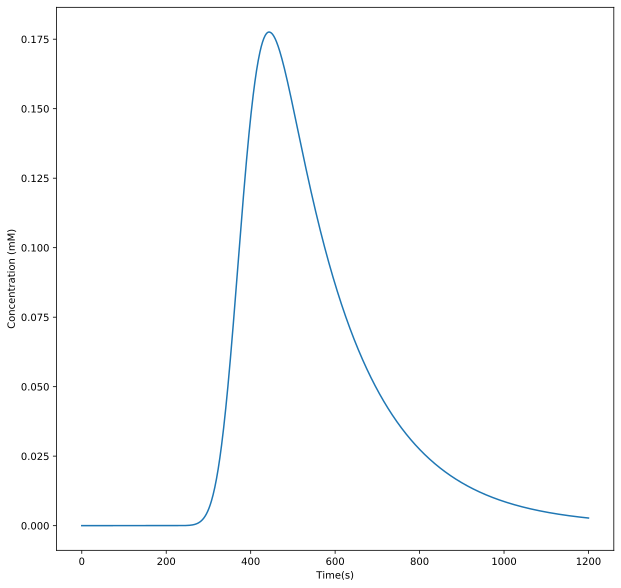

In [26]:
example_dir_0 = lesson_9 / "example_0"
example_dir_0.mkdir(exist_ok = True, parents=True)

example0 = Cadet()

#give a filename for where the simulation should be saved
example0.filename = (lesson_3 / "example_2" / 'example.h5').as_posix()

example0.load()

example0.filename = (example_dir_0 / 'example.h5').as_posix()

#remove the column (we will have to renumber some entries)

del example0.root.input.model.unit_001

#make the cstr unit_001

example0.root.input.model.unit_001 = example0.root.input.model.unit_005
del example0.root.input.model.unit_005

#this connects unit 0 to unit 1 and unit 1 to unit 2 with 2.88e-8 m^3/s with all components
example0.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, 2.88e-8,
                                                             1, 3, -1, -1, 2.88e-8,
                                                             3, 4, -1, -1, 2.88e-8,
                                                             4, 2, -1, -1, 2.88e-8]


#lower components to 1
example0.root.input.model.unit_001.ncomp = 1
example0.root.input.model.unit_002.ncomp = 1
example0.root.input.model.unit_003.ncomp = 1
example0.root.input.model.unit_004.ncomp = 1

example0.root.input.model.unit_003.discretization.nbound = [0,]
example0.root.input.model.unit_004.discretization.nbound = [0,]

#change the inlet to 1 component
#change the inlet
example0.root.input.model.unit_000.ncomp = 1

example0.root.input.model.unit_000.sec_000.const_coeff = [1.0,]
example0.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
example0.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
example0.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

example0.root.input.model.unit_000.sec_001.const_coeff = [0.0,]
example0.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]
example0.root.input.model.unit_000.sec_001.quad_coeff = [0.0,]
example0.root.input.model.unit_000.sec_001.cube_coeff = [0.0,]

del example0.root.input.model.unit_000.sec_002

#change the sections and section times

#solver settings
example0.root.input.solver.sections.section_times = [0.0, 50, 1200]

#set the times that the simulator writes out data for
example0.root.input.solver.user_solution_times = numpy.linspace(0, example0.root.input.solver.sections.section_times[-1], 
                                                               int(example0.root.input.solver.sections.section_times[-1]) + 1)

example0.root.input.solver.sections.nsec = len(example0.root.input.solver.sections.section_times) - 1


#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example0.root.output.solution.solution_times,
                        example0.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file

For the bypass data we will do error modeling on the dispersion in the tubing along with the volume of the CSTR. 

In [27]:
match0 = Dict()
match0.CADETPath = cadet_path.as_posix()
match0.baseDir = example_dir_0.as_posix()
match0.resultsDir = 'fit_mcmc'
match0.csv = 'fit_results.csv'
match0.checkpointFile = "check"
match0.searchMethod = 'NSGA3'
match0.population = 50
match0.finalGradRefinement = 0
match0.stallGenerations = 10
match0.continueMCMC = 1
match0.tempDir = 'L:/'


error_model = Dict()
error_model.file_path = "example.h5"
error_model.experimental_csv = "example.csv"
error_model.name = "main"
error_model.units = [2,]
error_model.delay = [0.0, 3.0]
error_model.flow = [1.0, 0.03]
error_model.load = [1.0, 0.03]
error_model.error_slope = [1.0, 0.001]
error_model.error_base = 50.0
error_model.base = 50.0
error_model.count = 1000

match0.kde_synthetic = [error_model,]

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_003/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-4

parameter2 = Dict()
parameter2.transform = 'set_value'
parameter2.componentFrom = -1
parameter2.boundFrom = -1
parameter2.locationFrom = "/input/model/unit_003/COL_DISPERSION"
parameter2.componentTo = -1
parameter2.boundTo = -1
parameter2.locationTo = "/input/model/unit_004/COL_DISPERSION"

parameter3 = Dict()
parameter3.transform = 'norm_log'
parameter3.component = -1
parameter3.bound = -1
parameter3.location = "/input/model/unit_001/INIT_VOLUME"
parameter3.min = 1e-4
parameter3.max = 1e-8

match0.parameters = [parameter1, parameter2, parameter3]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'ShapeDecay'

experiment1.features = [feature1,]

match0.experiments = [experiment1,]

match_file0 = example_dir_0 / 'example_bypass.json'

with (match_file0).open('w') as json_file:
    json.dump(match0.to_dict(), json_file, indent='\t')

## Run match

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc 


[2019-10-20 12:00:16,351] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 12:00:16,351] launcher  INFO    Deploying 6 worker(s) over 1 host(s).

[2019-10-20 12:00:16,351] launcher  INFO    Worker distribution: 

[2019-10-20 12:00:16,351] launcher  INFO       127.0.0.1:	5 + origin

[2019-10-20 12:00:19,125] util      (b'127.0.0.1:49334') INFO    example.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:00:19,349] match     (b'127.0.0.1:49334') INFO    simulation took 0.22397375106811523

[2019-10-20 12:00:19,370] match     (b'127.0.0.1:49334') INFO    create bias template for experiment main

[2019-10-20 12:00:19,664] gradFD    (b'127.0.0.1:49334') INFO    grad simulation took 0.22376060485839844

[2019-10-20 12:00:19,664] gradFD    (b'127.0.0.1:49334') INFO    grad C:/Users

[2019-10-20 12:03:08,104] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:08,111] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:08,114] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:08,149] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:08,437] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:08,450] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 12:03:11,727] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:11,814] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:11,921] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:11,949] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:11,985] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:12,125] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 12:03:15,399] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:15,455] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:15,458] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:15,458] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:15,538] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:15,897] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 12:03:18,989] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:18,998] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:19,072] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:19,085] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:19,121] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:19,418] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 12:03:22,125] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:22,271] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:22,293] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:22,315] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:22,370] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:22,386] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 12:03:25,428] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:25,532] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:25,562] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:25,593] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:25,690] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:25,757] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/le


[2019-10-20 12:03:28,625] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:28,644] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:28,682] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:28,724] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:28,852] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:28,886] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 12:03:31,935] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:32,017] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:32,045] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:32,121] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:32,146] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:32,149] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 12:03:35,302] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:35,417] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:35,473] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:35,476] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:35,495] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:35,513] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 12:03:38,648] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:38,803] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:38,884] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:38,916] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:38,950] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:38,980] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 12:03:42,221] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:42,383] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:42,405] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:42,431] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:42,443] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:42,460] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 12:03:45,683] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:45,703] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:45,803] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:45,808] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:45,818] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:45,908] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/le


[2019-10-20 12:03:49,032] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:49,137] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:49,158] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:49,163] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:49,168] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:49,256] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/le


[2019-10-20 12:03:52,124] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:52,364] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:52,379] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:52,405] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:52,452] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:52,538] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 12:03:55,712] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:55,718] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:55,862] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:55,944] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:55,944] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:55,980] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 12:03:59,214] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:59,399] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:59,454] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:59,454] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:59,534] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:03:59,544] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/le


[2019-10-20 12:04:02,654] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:02,704] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:02,806] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:02,943] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:02,950] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:03,022] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/le


[2019-10-20 12:04:05,882] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:06,054] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:06,123] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:06,144] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:06,230] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:06,258] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 12:04:09,368] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:09,423] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:09,435] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:09,562] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:09,586] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:09,650] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 12:04:12,789] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:12,927] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:12,980] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:12,989] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:12,991] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:13,166] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 12:04:16,092] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:16,312] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:16,341] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:16,364] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:16,426] util      (b'127.0.0.1:63967') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:16,479] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 12:04:19,712] util      (b'127.0.0.1:49637') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:19,780] util      (b'127.0.0.1:58260') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:19,803] util      (b'127.0.0.1:56043') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:19,838] util      (b'127.0.0.1:49334') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:19,853] util      (b'127.0.0.1:53541') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-20 12:04:22,378] loggerwriter (b'127.0.0.1:49334') INFO    differential_evolution step 1: f

[2019-10-20 12:08:55,893] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 42 accept: 0.452 std: 0.0117 mean: 0.441 converge: 23.4

[2019-10-20 12:09:01,931] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 43 accept: 0.454 std: 0.0117 mean: 0.441 converge: 23.5

[2019-10-20 12:09:08,004] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 44 accept: 0.456 std: 0.0118 mean: 0.441 converge: 23.6

[2019-10-20 12:09:14,235] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 45 accept: 0.457 std: 0.0119 mean: 0.442 converge: 23.8

[2019-10-20 12:09:20,202] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 46 accept: 0.457 std: 0.012 mean: 0.442 converge: 24

[2019-10-20 12:09:26,088] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 47 accept: 0.459 std: 0.0121 mean: 0.442 converge: 24.3

[2019-10-20 12:09:32,046] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 48 accept: 0.46 std: 0.0123 mean: 0.443 converge: 24.5

[2019-10-20 12:09:38,337] mcmc      (b'127.0.0.1:49334') INFO    b

[2019-10-20 12:15:08,580] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 104 accept: 0.481 std: 0.00624 mean: 0.469 converge: 12.5

[2019-10-20 12:15:14,362] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 105 accept: 0.481 std: 0.00631 mean: 0.47 converge: 12.6

[2019-10-20 12:15:20,421] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 106 accept: 0.482 std: 0.00641 mean: 0.47 converge: 12.8

[2019-10-20 12:15:26,403] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 107 accept: 0.481 std: 0.00645 mean: 0.471 converge: 12.9

[2019-10-20 12:15:32,127] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 108 accept: 0.481 std: 0.00643 mean: 0.471 converge: 12.9

[2019-10-20 12:15:38,166] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 109 accept: 0.481 std: 0.00638 mean: 0.471 converge: 12.8

[2019-10-20 12:15:44,357] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 110 accept: 0.482 std: 0.00637 mean: 0.472 converge: 12.7

[2019-10-20 12:15:50,081] mcmc      (b'127.0.0.1:4

[2019-10-20 12:20:51,862] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 159 accept: 0.49 std: 0.00262 mean: 0.487 converge: 5.24

[2019-10-20 12:20:59,091] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 160 accept: 0.49 std: 0.00259 mean: 0.487 converge: 5.19

[2019-10-20 12:21:05,870] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 161 accept: 0.49 std: 0.00256 mean: 0.487 converge: 5.12

[2019-10-20 12:21:12,181] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 162 accept: 0.491 std: 0.00255 mean: 0.487 converge: 5.09

[2019-10-20 12:21:18,383] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 163 accept: 0.491 std: 0.00254 mean: 0.487 converge: 5.08

[2019-10-20 12:21:24,934] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 164 accept: 0.491 std: 0.0025 mean: 0.487 converge: 5

[2019-10-20 12:21:31,417] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 165 accept: 0.491 std: 0.00246 mean: 0.488 converge: 4.93

[2019-10-20 12:21:37,883] mcmc      (b'127.0.0.1:49334'

[2019-10-20 12:26:21,652] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 209 accept: 0.499 std: 0.00289 mean: 0.495 converge: 5.78

[2019-10-20 12:26:27,980] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 210 accept: 0.499 std: 0.0029 mean: 0.495 converge: 5.79

[2019-10-20 12:26:34,824] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 211 accept: 0.499 std: 0.00289 mean: 0.495 converge: 5.79

[2019-10-20 12:26:41,547] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 212 accept: 0.499 std: 0.00289 mean: 0.495 converge: 5.78

[2019-10-20 12:26:48,184] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 213 accept: 0.499 std: 0.00289 mean: 0.495 converge: 5.78

[2019-10-20 12:26:55,193] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 214 accept: 0.499 std: 0.00287 mean: 0.495 converge: 5.75

[2019-10-20 12:27:02,426] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 215 accept: 0.5 std: 0.00286 mean: 0.496 converge: 5.71

[2019-10-20 12:27:09,650] mcmc      (b'127.0.0.1:49

[2019-10-20 12:33:39,128] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 270 accept: 0.504 std: 0.00157 mean: 0.502 converge: 3.14

[2019-10-20 12:33:46,171] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 271 accept: 0.505 std: 0.00157 mean: 0.502 converge: 3.15

[2019-10-20 12:33:53,116] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 272 accept: 0.505 std: 0.00156 mean: 0.502 converge: 3.12

[2019-10-20 12:34:00,263] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 273 accept: 0.505 std: 0.00155 mean: 0.502 converge: 3.09

[2019-10-20 12:34:07,253] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 274 accept: 0.505 std: 0.00153 mean: 0.502 converge: 3.06

[2019-10-20 12:34:14,166] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 275 accept: 0.505 std: 0.00152 mean: 0.502 converge: 3.04

[2019-10-20 12:34:21,152] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 276 accept: 0.505 std: 0.00151 mean: 0.502 converge: 3.02

[2019-10-20 12:34:28,442] mcmc      (b'127.0.0.1

[2019-10-20 12:40:42,716] generate_graphs (b'127.0.0.1:49311') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_0

[2019-10-20 12:40:45,074] launcher  (127.0.0.1:64590) INFO    Root process is done.

[2019-10-20 12:40:45,075] launcher  (127.0.0.1:64590) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 12:40:45,105] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 330 accept: 0.509 std: 0.00158 mean: 0.507 converge: 3.17

[2019-10-20 12:40:51,915] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 331 accept: 0.51 std: 0.00156 mean: 0.508 converge: 3.12

[2019-10-20 12:40:59,133] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 332 accept: 0.51 std: 0.00154 mean: 0.508 converge: 3.08

[2019-10-20 12:41:06,275] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 333 accept: 0.51 std: 0.00151 mean: 0.508 converge: 3.02

[2019-10-20 12:41:13,156] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 334 accept: 0.51 std: 0.00148 mean: 0.508 converge: 

[2019-10-20 12:46:33,400] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 378 accept: 0.512 std: 0.00087 mean: 0.511 converge: 1.74

[2019-10-20 12:46:40,959] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 379 accept: 0.512 std: 0.00085 mean: 0.511 converge: 1.7

[2019-10-20 12:46:47,766] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 380 accept: 0.512 std: 0.000827 mean: 0.511 converge: 1.65

[2019-10-20 12:46:54,616] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 381 accept: 0.512 std: 0.000801 mean: 0.511 converge: 1.6

[2019-10-20 12:47:01,476] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 382 accept: 0.512 std: 0.000782 mean: 0.511 converge: 1.56

[2019-10-20 12:47:08,757] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 383 accept: 0.512 std: 0.000749 mean: 0.511 converge: 1.5

[2019-10-20 12:47:15,834] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 384 accept: 0.512 std: 0.000713 mean: 0.511 converge: 1.43

[2019-10-20 12:47:22,448] mcmc      (b'127.0.0

[2019-10-20 12:53:26,263] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 437 accept: 0.413 std: 0.0145 mean: 0.401 converge: 29.1

[2019-10-20 12:53:33,119] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 438 accept: 0.414 std: 0.0145 mean: 0.401 converge: 29

[2019-10-20 12:53:39,931] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 439 accept: 0.414 std: 0.0145 mean: 0.402 converge: 28.9

[2019-10-20 12:53:47,065] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 440 accept: 0.415 std: 0.0144 mean: 0.402 converge: 28.9

[2019-10-20 12:53:54,263] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 441 accept: 0.415 std: 0.0144 mean: 0.402 converge: 28.8

[2019-10-20 12:54:01,309] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 442 accept: 0.416 std: 0.0142 mean: 0.403 converge: 28.4

[2019-10-20 12:54:08,173] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 443 accept: 0.415 std: 0.0116 mean: 0.404 converge: 23.3

[2019-10-20 12:54:15,120] mcmc      (b'127.0.0.1:49334') 

[2019-10-20 13:00:50,260] generate_graphs (b'127.0.0.1:50595') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_0

[2019-10-20 13:00:52,164] launcher  (127.0.0.1:65029) INFO    Root process is done.

[2019-10-20 13:00:52,165] launcher  (127.0.0.1:65029) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 13:00:52,199] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 496 accept: 0.427 std: 0.00484 mean: 0.422 converge: 9.68

[2019-10-20 13:01:00,154] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 497 accept: 0.427 std: 0.00476 mean: 0.422 converge: 9.53

[2019-10-20 13:01:07,645] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 498 accept: 0.427 std: 0.00462 mean: 0.423 converge: 9.24

[2019-10-20 13:01:15,196] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 499 accept: 0.427 std: 0.00446 mean: 0.423 converge: 8.91

[2019-10-20 13:01:23,223] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 500 accept: 0.426 std: 0.0043 mean: 0.423 converg

[2019-10-20 13:06:04,222] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 532 accept: 0.425 std: 0.00142 mean: 0.426 converge: 2.84

[2019-10-20 13:06:12,814] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 533 accept: 0.426 std: 0.00138 mean: 0.425 converge: 2.75

[2019-10-20 13:06:21,215] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 534 accept: 0.426 std: 0.00134 mean: 0.425 converge: 2.68

[2019-10-20 13:06:29,766] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 535 accept: 0.425 std: 0.00129 mean: 0.425 converge: 2.58

[2019-10-20 13:06:38,334] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 536 accept: 0.425 std: 0.00123 mean: 0.425 converge: 2.46

[2019-10-20 13:06:46,873] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 537 accept: 0.425 std: 0.00118 mean: 0.425 converge: 2.36

[2019-10-20 13:06:55,347] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 538 accept: 0.425 std: 0.00116 mean: 0.425 converge: 2.32

[2019-10-20 13:07:03,742] mcmc      (b'127.0.0.1

[2019-10-20 13:14:20,287] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 591 accept: 0.318 std: 0.00882 mean: 0.323 converge: 17.6

[2019-10-20 13:14:28,495] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 592 accept: 0.317 std: 0.00877 mean: 0.323 converge: 17.5

[2019-10-20 13:14:36,541] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 593 accept: 0.317 std: 0.0087 mean: 0.323 converge: 17.4

[2019-10-20 13:14:44,888] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 594 accept: 0.317 std: 0.00864 mean: 0.323 converge: 17.3

[2019-10-20 13:14:53,058] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 595 accept: 0.318 std: 0.00858 mean: 0.323 converge: 17.2

[2019-10-20 13:15:01,381] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 596 accept: 0.316 std: 0.00853 mean: 0.323 converge: 17.1

[2019-10-20 13:15:09,865] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 597 accept: 0.316 std: 0.00849 mean: 0.323 converge: 17

[2019-10-20 13:15:18,160] mcmc      (b'127.0.0.1:49

[2019-10-20 13:21:57,944] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 646 accept: 0.32 std: 0.00219 mean: 0.318 converge: 4.37

[2019-10-20 13:22:05,805] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 647 accept: 0.321 std: 0.0022 mean: 0.318 converge: 4.39

[2019-10-20 13:22:13,765] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 648 accept: 0.32 std: 0.0022 mean: 0.318 converge: 4.39

[2019-10-20 13:22:21,460] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 649 accept: 0.321 std: 0.00217 mean: 0.318 converge: 4.35

[2019-10-20 13:22:28,776] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 650 accept: 0.321 std: 0.00216 mean: 0.319 converge: 4.32

[2019-10-20 13:22:36,418] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 651 accept: 0.321 std: 0.00213 mean: 0.319 converge: 4.26

[2019-10-20 13:22:44,187] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 652 accept: 0.32 std: 0.00208 mean: 0.319 converge: 4.15

[2019-10-20 13:22:51,941] mcmc      (b'127.0.0.1:4933

[2019-10-20 13:28:37,780] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 697 accept: 0.321 std: 0.00115 mean: 0.32 converge: 2.3

[2019-10-20 13:28:45,751] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 698 accept: 0.322 std: 0.00118 mean: 0.32 converge: 2.36

[2019-10-20 13:28:54,288] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 699 accept: 0.322 std: 0.00121 mean: 0.32 converge: 2.42

[2019-10-20 13:29:02,551] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 700 accept: 0.321 std: 0.00122 mean: 0.32 converge: 2.43

[2019-10-20 13:29:10,588] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 701 accept: 0.322 std: 0.00125 mean: 0.32 converge: 2.5

[2019-10-20 13:29:18,685] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 702 accept: 0.322 std: 0.00128 mean: 0.32 converge: 2.56

[2019-10-20 13:29:26,351] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 703 accept: 0.322 std: 0.00131 mean: 0.32 converge: 2.61

[2019-10-20 13:29:34,142] mcmc      (b'127.0.0.1:49334') 

[2019-10-20 13:36:28,338] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 756 accept: 0.262 std: 0.0105 mean: 0.244 converge: 21.1

[2019-10-20 13:36:36,524] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 757 accept: 0.266 std: 0.0114 mean: 0.245 converge: 22.7

[2019-10-20 13:36:44,790] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 758 accept: 0.266 std: 0.0119 mean: 0.246 converge: 23.9

[2019-10-20 13:36:52,982] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 759 accept: 0.265 std: 0.0124 mean: 0.247 converge: 24.7

[2019-10-20 13:37:00,754] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 760 accept: 0.268 std: 0.0128 mean: 0.248 converge: 25.6

[2019-10-20 13:37:08,529] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 761 accept: 0.268 std: 0.0132 mean: 0.249 converge: 26.4

[2019-10-20 13:37:16,727] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 762 accept: 0.269 std: 0.0135 mean: 0.249 converge: 27.1

[2019-10-20 13:37:25,056] mcmc      (b'127.0.0.1:49334'

[2019-10-20 13:43:45,880] generate_corner_graphs (b'127.0.0.1:52224') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_0

[2019-10-20 13:43:45,880] generate_corner_graphs (b'127.0.0.1:52224') INFO    plotting corner plots

[2019-10-20 13:43:45,891] generate_corner_graphs (b'127.0.0.1:52224') INFO    plot burn in acceptance

[2019-10-20 13:43:46,050] generate_corner_graphs (b'127.0.0.1:52224') INFO    plotting chain

[2019-10-20 13:43:47,006] generate_corner_graphs (b'127.0.0.1:52224') INFO    plotting mcmc param 0

[2019-10-20 13:43:47,166] generate_corner_graphs (b'127.0.0.1:52224') INFO    plotting mcmc param 0

[2019-10-20 13:43:47,331] generate_corner_graphs (b'127.0.0.1:52224') INFO    plotting mcmc param 1

[2019-10-20 13:43:47,482] generate_corner_graphs (b'127.0.0.1:52224') INFO    plotting mcmc param 1

[2019-10-20 13:43:48,181] launcher  (127.0.0.1:50277) INFO    Root process is done.

[2019-10-20 13:43:48,182] launcher  (127.0.0.1:50277) INFO    Fi

[2019-10-20 13:50:58,789] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 863 accept: 0.263 std: 0.000829 mean: 0.262 converge: 1.66

[2019-10-20 13:51:06,807] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 864 accept: 0.263 std: 0.000796 mean: 0.262 converge: 1.59

[2019-10-20 13:51:14,578] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 865 accept: 0.263 std: 0.000766 mean: 0.262 converge: 1.53

[2019-10-20 13:51:22,163] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 866 accept: 0.263 std: 0.000751 mean: 0.262 converge: 1.5

[2019-10-20 13:51:29,192] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 867 accept: 0.263 std: 0.000751 mean: 0.262 converge: 1.5

[2019-10-20 13:51:36,574] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 868 accept: 0.264 std: 0.000768 mean: 0.262 converge: 1.54

[2019-10-20 13:51:44,122] mcmc      (b'127.0.0.1:49334') INFO    burn:  idx: 869 accept: 0.264 std: 0.000814 mean: 0.262 converge: 1.63

[2019-10-20 13:51:52,469] mcmc      (b'127.

[2019-10-20 13:59:13,081] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 0 accept: 0.290

[2019-10-20 13:59:18,701] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1 accept: 0.285

[2019-10-20 13:59:24,443] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2 accept: 0.300

[2019-10-20 13:59:30,539] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 3 accept: 0.307

[2019-10-20 13:59:36,713] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 4 accept: 0.304

[2019-10-20 13:59:42,539] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 5 accept: 0.292

[2019-10-20 13:59:48,623] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 6 accept: 0.296

[2019-10-20 13:59:55,133] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 7 accept: 0.294

[2019-10-20 14:00:01,956] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 8 accept: 0.291

[2019-10-20 14:00:08,867] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 9 accept: 0.293

[2019-10-20 14:00:15,798] mcmc      (b'127.0.0.1:49334') INFO    run: 

[2019-10-20 14:04:09,589] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 40 accept: 0.280

[2019-10-20 14:04:16,345] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 41 accept: 0.281

[2019-10-20 14:04:22,556] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 42 accept: 0.280

[2019-10-20 14:04:28,655] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 43 accept: 0.280

[2019-10-20 14:04:34,959] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 44 accept: 0.279

[2019-10-20 14:04:41,344] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 45 accept: 0.279

[2019-10-20 14:04:47,308] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 46 accept: 0.279

[2019-10-20 14:04:53,154] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 47 accept: 0.279

[2019-10-20 14:04:59,303] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 48 accept: 0.278

[2019-10-20 14:05:05,421] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 49 accept: 0.277

[2019-10-20 14:05:05,430] mcmc      (b'127.0.0.1:49334') INF

[2019-10-20 14:11:39,167] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 115 accept: 0.276

[2019-10-20 14:11:45,269] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 116 accept: 0.277

[2019-10-20 14:11:51,362] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 117 accept: 0.277

[2019-10-20 14:11:57,467] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 118 accept: 0.277

[2019-10-20 14:12:03,431] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 119 accept: 0.276

[2019-10-20 14:12:09,357] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 120 accept: 0.276

[2019-10-20 14:12:15,540] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 121 accept: 0.277

[2019-10-20 14:12:21,461] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 122 accept: 0.277

[2019-10-20 14:12:27,309] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 123 accept: 0.276

[2019-10-20 14:12:33,424] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 124 accept: 0.276

[2019-10-20 14:12:33,436] mcmc      (b'127.0.0.1:4

[2019-10-20 14:19:04,072] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 189 accept: 0.272

[2019-10-20 14:19:10,060] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 190 accept: 0.272

[2019-10-20 14:19:16,198] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 191 accept: 0.272

[2019-10-20 14:19:22,609] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 192 accept: 0.272

[2019-10-20 14:19:28,481] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 193 accept: 0.272

[2019-10-20 14:19:34,381] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 194 accept: 0.271

[2019-10-20 14:19:40,403] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 195 accept: 0.271

[2019-10-20 14:19:46,280] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 196 accept: 0.271

[2019-10-20 14:19:52,252] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 197 accept: 0.271

[2019-10-20 14:19:58,160] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 198 accept: 0.271

[2019-10-20 14:20:04,421] mcmc      (b'127.0.0.1:4

[2019-10-20 14:24:05,529] launcher  (127.0.0.1:51427) INFO    Root process is done.

[2019-10-20 14:24:05,530] launcher  (127.0.0.1:51427) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 14:24:11,454] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 238 accept: 0.271

[2019-10-20 14:24:17,360] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 239 accept: 0.272

[2019-10-20 14:24:23,440] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 240 accept: 0.272

[2019-10-20 14:24:29,263] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 241 accept: 0.272

[2019-10-20 14:24:35,077] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 242 accept: 0.272

[2019-10-20 14:24:41,050] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 243 accept: 0.272

[2019-10-20 14:24:47,042] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 244 accept: 0.272

[2019-10-20 14:24:53,042] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 245 accept: 0.272

[2019-10-20 14:24:59,089] mcmc      (b'127.0.0.1:493

[2019-10-20 14:31:34,706] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 311 accept: 0.271

[2019-10-20 14:31:40,627] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 312 accept: 0.272

[2019-10-20 14:31:46,647] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 313 accept: 0.271

[2019-10-20 14:31:52,657] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 314 accept: 0.271

[2019-10-20 14:31:58,401] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 315 accept: 0.271

[2019-10-20 14:32:04,373] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 316 accept: 0.271

[2019-10-20 14:32:10,454] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 317 accept: 0.271

[2019-10-20 14:32:16,336] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 318 accept: 0.271

[2019-10-20 14:32:22,266] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 319 accept: 0.271

[2019-10-20 14:32:28,394] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 320 accept: 0.271

[2019-10-20 14:32:34,350] mcmc      (b'127.0.0.1:4

[2019-10-20 14:38:58,801] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 385 accept: 0.273

[2019-10-20 14:39:04,679] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 386 accept: 0.273

[2019-10-20 14:39:10,583] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 387 accept: 0.273

[2019-10-20 14:39:16,593] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 388 accept: 0.273

[2019-10-20 14:39:22,977] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 389 accept: 0.273

[2019-10-20 14:39:28,710] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 390 accept: 0.273

[2019-10-20 14:39:34,758] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 391 accept: 0.273

[2019-10-20 14:39:40,671] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 392 accept: 0.273

[2019-10-20 14:39:46,755] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 393 accept: 0.273

[2019-10-20 14:39:52,605] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 394 accept: 0.273

[2019-10-20 14:39:58,595] mcmc      (b'127.0.0.1:4

[2019-10-20 14:44:16,685] generate_corner_graphs (b'127.0.0.1:60824') INFO    plotting mcmc param 1

[2019-10-20 14:44:16,819] generate_corner_graphs (b'127.0.0.1:60824') INFO    plotting mcmc param 1

[2019-10-20 14:44:17,462] launcher  (127.0.0.1:51856) INFO    Root process is done.

[2019-10-20 14:44:17,462] launcher  (127.0.0.1:51856) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 14:44:22,937] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 437 accept: 0.274

[2019-10-20 14:44:28,617] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 438 accept: 0.274

[2019-10-20 14:44:34,357] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 439 accept: 0.274

[2019-10-20 14:44:40,318] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 440 accept: 0.274

[2019-10-20 14:44:46,166] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 441 accept: 0.274

[2019-10-20 14:44:52,383] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 442 accept: 0.274

[2019-10-20 14:44:58,432] mcmc      (b'1

[2019-10-20 14:51:27,415] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 507 accept: 0.274

[2019-10-20 14:51:33,407] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 508 accept: 0.274

[2019-10-20 14:51:39,297] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 509 accept: 0.274

[2019-10-20 14:51:45,177] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 510 accept: 0.274

[2019-10-20 14:51:51,139] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 511 accept: 0.274

[2019-10-20 14:51:57,453] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 512 accept: 0.274

[2019-10-20 14:52:03,501] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 513 accept: 0.274

[2019-10-20 14:52:09,427] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 514 accept: 0.274

[2019-10-20 14:52:15,394] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 515 accept: 0.274

[2019-10-20 14:52:21,428] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 516 accept: 0.274

[2019-10-20 14:52:27,326] mcmc      (b'127.0.0.1:4

[2019-10-20 14:58:53,947] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 581 accept: 0.274

[2019-10-20 14:59:00,039] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 582 accept: 0.274

[2019-10-20 14:59:06,100] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 583 accept: 0.274

[2019-10-20 14:59:12,167] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 584 accept: 0.274

[2019-10-20 14:59:18,493] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 585 accept: 0.274

[2019-10-20 14:59:19,429] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 14:59:19,429] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-20 14:59:19,430] launcher  INFO    Worker distribution: 

[2019-10-20 14:59:19,430] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-20 14:59:23,510] mle       (b'127.0.0.1:58199') INFO    process mle chain shape before (48700, 2)

[2019-10

[2019-10-20 15:06:56,942] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 51: f(x)= -0.817089

[2019-10-20 15:07:00,215] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 52: f(x)= -0.817089

[2019-10-20 15:07:03,426] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 53: f(x)= -0.817089

[2019-10-20 15:07:07,139] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 54: f(x)= -0.817089

[2019-10-20 15:07:10,780] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 55: f(x)= -0.817089

[2019-10-20 15:07:14,306] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 56: f(x)= -0.818894

[2019-10-20 15:07:17,690] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 57: f(x)= -0.818894

[2019-10-20 15:07:20,898] loggerwriter (b'127.0.0.1:58199') INFO    differential_evolution step 58: f(x)= -0.818894

[2019-10-20 15:07:24,323] loggerwriter (b'127.0.0.1:58199') INFO

[2019-10-20 15:09:13,758] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 587 accept: 0.273

[2019-10-20 15:09:19,644] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 588 accept: 0.273

[2019-10-20 15:09:25,405] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 589 accept: 0.273

[2019-10-20 15:09:31,864] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 590 accept: 0.273

[2019-10-20 15:09:38,360] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 591 accept: 0.273

[2019-10-20 15:09:44,747] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 592 accept: 0.273

[2019-10-20 15:09:50,835] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 593 accept: 0.273

[2019-10-20 15:09:56,848] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 594 accept: 0.273

[2019-10-20 15:10:02,933] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 595 accept: 0.273

[2019-10-20 15:10:09,105] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 596 accept: 0.273

[2019-10-20 15:10:15,628] mcmc      (b'127.0.0.1:4

[2019-10-20 15:17:08,278] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 661 accept: 0.273

[2019-10-20 15:17:14,572] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 662 accept: 0.273

[2019-10-20 15:17:20,509] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 663 accept: 0.273

[2019-10-20 15:17:26,532] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 664 accept: 0.273

[2019-10-20 15:17:32,689] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 665 accept: 0.273

[2019-10-20 15:17:38,734] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 666 accept: 0.273

[2019-10-20 15:17:44,721] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 667 accept: 0.273

[2019-10-20 15:17:50,874] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 668 accept: 0.273

[2019-10-20 15:17:57,046] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 669 accept: 0.273

[2019-10-20 15:18:03,103] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 670 accept: 0.273

[2019-10-20 15:18:09,365] mcmc      (b'127.0.0.1:4

[2019-10-20 15:25:19,647] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 735 accept: 0.273

[2019-10-20 15:25:26,847] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 736 accept: 0.273

[2019-10-20 15:25:33,997] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 737 accept: 0.273

[2019-10-20 15:25:40,700] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 738 accept: 0.273

[2019-10-20 15:25:47,555] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 739 accept: 0.273

[2019-10-20 15:25:54,845] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 740 accept: 0.273

[2019-10-20 15:26:02,631] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 741 accept: 0.273

[2019-10-20 15:26:11,095] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 742 accept: 0.273

[2019-10-20 15:26:19,109] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 743 accept: 0.273

[2019-10-20 15:26:27,481] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 744 accept: 0.273

[2019-10-20 15:26:35,755] mcmc      (b'127.0.0.1:4

[2019-10-20 15:31:39,456] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 782 accept: 0.273

[2019-10-20 15:31:46,353] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 783 accept: 0.273

[2019-10-20 15:31:53,280] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 784 accept: 0.273

[2019-10-20 15:32:01,787] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 785 accept: 0.273

[2019-10-20 15:32:10,085] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 786 accept: 0.272

[2019-10-20 15:32:17,616] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 787 accept: 0.272

[2019-10-20 15:32:25,472] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 788 accept: 0.273

[2019-10-20 15:32:32,632] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 789 accept: 0.272

[2019-10-20 15:32:40,334] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 790 accept: 0.272

[2019-10-20 15:32:48,015] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 791 accept: 0.272

[2019-10-20 15:32:56,751] mcmc      (b'127.0.0.1:4

[2019-10-20 15:41:33,977] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 856 accept: 0.272

[2019-10-20 15:41:41,942] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 857 accept: 0.272

[2019-10-20 15:41:49,654] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 858 accept: 0.272

[2019-10-20 15:41:57,331] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 859 accept: 0.272

[2019-10-20 15:42:05,276] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 860 accept: 0.272

[2019-10-20 15:42:13,390] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 861 accept: 0.272

[2019-10-20 15:42:21,440] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 862 accept: 0.272

[2019-10-20 15:42:29,027] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 863 accept: 0.272

[2019-10-20 15:42:36,315] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 864 accept: 0.272

[2019-10-20 15:42:44,081] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 865 accept: 0.272

[2019-10-20 15:42:51,964] mcmc      (b'127.0.0.1:4

[2019-10-20 15:48:47,939] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 911 accept: 0.272

[2019-10-20 15:48:55,659] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 912 accept: 0.272

[2019-10-20 15:49:03,575] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 913 accept: 0.272

[2019-10-20 15:49:11,453] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 914 accept: 0.272

[2019-10-20 15:49:19,916] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 15:49:19,916] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-20 15:49:19,916] launcher  INFO    Worker distribution: 

[2019-10-20 15:49:19,916] launcher  INFO       127.0.0.1:	3 + origin

[2019-10-20 15:49:23,105] generate_graphs (b'127.0.0.1:53775') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_0

[2019-10-20 15:49:24,773] launcher  (127.0.0.1:53556) INFO    Root proc

[2019-10-20 15:57:32,603] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 978 accept: 0.271

[2019-10-20 15:57:40,687] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 979 accept: 0.271

[2019-10-20 15:57:48,495] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 980 accept: 0.271

[2019-10-20 15:57:55,854] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 981 accept: 0.271

[2019-10-20 15:58:03,635] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 982 accept: 0.271

[2019-10-20 15:58:11,701] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 983 accept: 0.271

[2019-10-20 15:58:19,146] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 984 accept: 0.271

[2019-10-20 15:58:27,050] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 985 accept: 0.271

[2019-10-20 15:58:34,938] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 986 accept: 0.271

[2019-10-20 15:58:42,515] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 987 accept: 0.271

[2019-10-20 15:58:49,993] mcmc      (b'127.0.0.1:4

[2019-10-20 16:07:18,216] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1052 accept: 0.271

[2019-10-20 16:07:27,201] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1053 accept: 0.271

[2019-10-20 16:07:36,297] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1054 accept: 0.271

[2019-10-20 16:07:45,033] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1055 accept: 0.271

[2019-10-20 16:07:53,786] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1056 accept: 0.271

[2019-10-20 16:08:02,594] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1057 accept: 0.271

[2019-10-20 16:08:11,390] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1058 accept: 0.271

[2019-10-20 16:08:12,378] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 16:08:12,378] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-20 16:08:12,378] launcher  INFO    Worker distri

[2019-10-20 16:17:49,176] loggerwriter (b'127.0.0.1:60739') INFO    differential_evolution step 49: f(x)= -0.110247

[2019-10-20 16:17:52,717] loggerwriter (b'127.0.0.1:60739') INFO    differential_evolution step 50: f(x)= -0.11034

[2019-10-20 16:17:56,230] loggerwriter (b'127.0.0.1:60739') INFO    differential_evolution step 51: f(x)= -0.11034

[2019-10-20 16:17:59,675] loggerwriter (b'127.0.0.1:60739') INFO    differential_evolution step 52: f(x)= -0.110343

[2019-10-20 16:18:03,049] loggerwriter (b'127.0.0.1:60739') INFO    differential_evolution step 53: f(x)= -0.110343

[2019-10-20 16:18:06,644] loggerwriter (b'127.0.0.1:60739') INFO    differential_evolution step 54: f(x)= -0.110343

[2019-10-20 16:18:06,647] mle       (b'127.0.0.1:60739') INFO    finished mle search

[2019-10-20 16:18:06,647] mle       (b'127.0.0.1:60739') INFO    mle found [0.8896357571630709, 0.32799676919003534]

[2019-10-20 16:18:06,647] mle       (b'127.0.0.1:60739') INFO    mle_x: [0.8896357571630709, 0.3

[2019-10-20 16:20:40,826] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1071 accept: 0.271

[2019-10-20 16:20:47,539] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1072 accept: 0.271

[2019-10-20 16:20:54,654] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1073 accept: 0.271

[2019-10-20 16:21:02,081] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1074 accept: 0.271

[2019-10-20 16:21:02,123] mcmc      (b'127.0.0.1:49334') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 22;

tau: [36.45048445 29.90223495]

[2019-10-20 16:21:02,124] mcmc      (b'127.0.0.1:49334') INFO    Mean acceptance fraction: 1075 0.271 tau: [36.45048445 29.90223495]

[2019-10-20 16:21:09,424] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1075 accept: 0.271

[2019-10-20 16:21:16,531] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1076 accept: 0.271

[2019-10-20 16:21:23,114] mcmc    

[2019-10-20 16:30:09,009] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1145 accept: 0.271

[2019-10-20 16:30:16,568] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1146 accept: 0.271

[2019-10-20 16:30:24,560] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1147 accept: 0.271

[2019-10-20 16:30:33,062] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1148 accept: 0.271

[2019-10-20 16:30:41,914] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1149 accept: 0.271

[2019-10-20 16:30:41,968] mcmc      (b'127.0.0.1:49334') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 23;

tau: [38.15674895 30.64293311]

[2019-10-20 16:30:41,969] mcmc      (b'127.0.0.1:49334') INFO    Mean acceptance fraction: 1150 0.271 tau: [38.15674895 30.64293311]

[2019-10-20 16:30:50,515] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1150 accept: 0.271

[2019-10-20 16:30:58,879] mcmc    

[2019-10-20 16:38:27,235] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 0

[2019-10-20 16:38:27,392] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 0

[2019-10-20 16:38:27,561] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 0

[2019-10-20 16:38:27,751] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 0

[2019-10-20 16:38:27,954] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 1

[2019-10-20 16:38:28,117] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 1

[2019-10-20 16:38:28,277] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 1

[2019-10-20 16:38:28,459] generate_corner_graphs (b'127.0.0.1:50537') INFO    plotting mcmc param 1

[2019-10-20 16:38:29,219] launcher  (127.0.0.1:54861) INFO    Root process is done.

[2019-10-20 16:38:29,220] launcher  (127.0.0.1:54861) INFO    Finished cleaning spawned subprocesses.

[201

[2019-10-20 16:46:35,750] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1266 accept: 0.272

[2019-10-20 16:46:43,811] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1267 accept: 0.272

[2019-10-20 16:46:51,872] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1268 accept: 0.272

[2019-10-20 16:46:59,476] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1269 accept: 0.272

[2019-10-20 16:47:07,320] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1270 accept: 0.271

[2019-10-20 16:47:15,253] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1271 accept: 0.271

[2019-10-20 16:47:23,336] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1272 accept: 0.271

[2019-10-20 16:47:31,009] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1273 accept: 0.271

[2019-10-20 16:47:38,978] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1274 accept: 0.271

[2019-10-20 16:47:39,027] mcmc      (b'127.0.0.1:49334') INFO    The chain is shorter than 50 times the integrated autocorrelation time 

[2019-10-20 16:56:14,973] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1340 accept: 0.271

[2019-10-20 16:56:22,227] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1341 accept: 0.271

[2019-10-20 16:56:29,177] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1342 accept: 0.271

[2019-10-20 16:56:36,373] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1343 accept: 0.271

[2019-10-20 16:56:44,143] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1344 accept: 0.271

[2019-10-20 16:56:51,830] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1345 accept: 0.271

[2019-10-20 16:56:59,668] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1346 accept: 0.271

[2019-10-20 16:57:07,314] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1347 accept: 0.271

[2019-10-20 16:57:14,814] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1348 accept: 0.271

[2019-10-20 16:57:22,316] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1349 accept: 0.271

[2019-10-20 16:57:22,368] mcmc      (b'1

[2019-10-20 17:02:39,921] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1387 accept: 0.271

[2019-10-20 17:02:47,930] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1388 accept: 0.271

[2019-10-20 17:02:55,069] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1389 accept: 0.271

[2019-10-20 17:03:02,246] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1390 accept: 0.271

[2019-10-20 17:03:10,536] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1391 accept: 0.271

[2019-10-20 17:03:17,725] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1392 accept: 0.271

[2019-10-20 17:03:24,762] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1393 accept: 0.271

[2019-10-20 17:03:31,845] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1394 accept: 0.271

[2019-10-20 17:03:39,197] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1395 accept: 0.271

[2019-10-20 17:03:46,662] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1396 accept: 0.271

[2019-10-20 17:03:55,503] mcmc      (b'1

[2019-10-20 17:12:29,059] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1461 accept: 0.271

[2019-10-20 17:12:37,306] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1462 accept: 0.271

[2019-10-20 17:12:45,747] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1463 accept: 0.271

[2019-10-20 17:12:53,894] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1464 accept: 0.271

[2019-10-20 17:13:01,889] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1465 accept: 0.271

[2019-10-20 17:13:10,366] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1466 accept: 0.271

[2019-10-20 17:13:18,497] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1467 accept: 0.271

[2019-10-20 17:13:26,554] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1468 accept: 0.271

[2019-10-20 17:13:34,844] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1469 accept: 0.271

[2019-10-20 17:13:43,586] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1470 accept: 0.271

[2019-10-20 17:13:51,990] mcmc      (b'1

[2019-10-20 17:27:12,801] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 18: f(x)= 0.389047

[2019-10-20 17:27:16,169] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 19: f(x)= 0.389047

[2019-10-20 17:27:19,440] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 20: f(x)= 0.389047

[2019-10-20 17:27:24,199] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 21: f(x)= 0.389047

[2019-10-20 17:27:29,105] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 22: f(x)= 0.389047

[2019-10-20 17:27:33,860] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 23: f(x)= 0.261244

[2019-10-20 17:27:37,876] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 24: f(x)= 0.261244

[2019-10-20 17:27:41,654] loggerwriter (b'127.0.0.1:61665') INFO    differential_evolution step 25: f(x)= 0.261244

[2019-10-20 17:27:45,305] loggerwriter (b'127.0.0.1:61665') INFO    diff

[2019-10-20 17:29:52,389] generate_graphs (b'127.0.0.1:64954') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_0

[2019-10-20 17:30:16,899] loggerwriter (b'127.0.0.1:64954') WARNING generate_graphs.py:470: RuntimeWarning: divide by zero encountered in double_scalars

  score_scale = numpy.max(scores)/numpy.min(scores)



[2019-10-20 17:30:16,903] loggerwriter (b'127.0.0.1:64954') WARNING generate_graphs.py:473: RuntimeWarning: divide by zero encountered in log

  scores = numpy.log(scores)



generate_graphs.py:470: RuntimeWarning: divide by zero encountered in double_scalars

  score_scale = numpy.max(scores)/numpy.min(scores)

generate_graphs.py:473: RuntimeWarning: divide by zero encountered in log

  scores = numpy.log(scores)

generate_graphs.py:470: RuntimeWarning: divide by zero encountered in double_scalars

  score_scale = numpy.max(scores)/numpy.min(scores)

generate_graphs.py:473: RuntimeWarning: divide by zero encountered in log

  scores = numpy

[2019-10-20 17:38:59,200] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1559 accept: 0.272

[2019-10-20 17:39:07,974] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1560 accept: 0.272

[2019-10-20 17:39:16,745] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1561 accept: 0.272

[2019-10-20 17:39:25,054] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1562 accept: 0.272

[2019-10-20 17:39:32,951] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1563 accept: 0.272

[2019-10-20 17:39:40,205] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1564 accept: 0.272

[2019-10-20 17:39:47,772] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1565 accept: 0.272

[2019-10-20 17:39:54,998] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1566 accept: 0.272

[2019-10-20 17:40:01,466] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1567 accept: 0.272

[2019-10-20 17:40:09,256] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1568 accept: 0.272

[2019-10-20 17:40:16,174] mcmc      (b'1

[2019-10-20 17:47:55,215] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1633 accept: 0.271

[2019-10-20 17:48:01,195] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1634 accept: 0.271

[2019-10-20 17:48:07,222] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1635 accept: 0.271

[2019-10-20 17:48:13,411] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1636 accept: 0.271

[2019-10-20 17:48:19,230] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1637 accept: 0.271

[2019-10-20 17:48:25,084] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1638 accept: 0.271

[2019-10-20 17:48:31,092] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1639 accept: 0.271

[2019-10-20 17:48:36,962] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1640 accept: 0.271

[2019-10-20 17:48:42,615] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1641 accept: 0.271

[2019-10-20 17:48:48,482] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1642 accept: 0.271

[2019-10-20 17:48:54,427] mcmc      (b'1

[2019-10-20 17:53:07,135] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1680 accept: 0.272

[2019-10-20 17:53:13,569] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1681 accept: 0.272

[2019-10-20 17:53:20,093] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1682 accept: 0.272

[2019-10-20 17:53:26,757] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1683 accept: 0.272

[2019-10-20 17:53:33,294] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1684 accept: 0.272

[2019-10-20 17:53:39,678] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1685 accept: 0.272

[2019-10-20 17:53:46,079] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1686 accept: 0.272

[2019-10-20 17:53:52,883] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1687 accept: 0.271

[2019-10-20 17:53:59,582] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1688 accept: 0.271

[2019-10-20 17:54:06,091] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1689 accept: 0.271

[2019-10-20 17:54:12,553] mcmc      (b'1

[2019-10-20 18:01:12,279] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1754 accept: 0.271

[2019-10-20 18:01:19,292] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1755 accept: 0.271

[2019-10-20 18:01:26,147] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1756 accept: 0.271

[2019-10-20 18:01:33,302] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1757 accept: 0.271

[2019-10-20 18:01:40,317] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1758 accept: 0.271

[2019-10-20 18:01:46,704] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1759 accept: 0.271

[2019-10-20 18:01:53,445] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1760 accept: 0.271

[2019-10-20 18:01:59,830] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1761 accept: 0.271

[2019-10-20 18:02:06,314] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1762 accept: 0.271

[2019-10-20 18:02:12,704] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1763 accept: 0.271

[2019-10-20 18:02:18,984] mcmc      (b'1

[2019-10-20 18:09:26,864] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1828 accept: 0.271

[2019-10-20 18:09:33,030] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1829 accept: 0.271

[2019-10-20 18:09:39,437] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1830 accept: 0.271

[2019-10-20 18:09:45,798] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1831 accept: 0.271

[2019-10-20 18:09:52,257] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1832 accept: 0.271

[2019-10-20 18:09:58,425] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1833 accept: 0.271

[2019-10-20 18:09:59,364] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 18:09:59,364] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-20 18:09:59,365] launcher  INFO    Worker distribution: 

[2019-10-20 18:09:59,365] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-20 18:10

[2019-10-20 18:14:32,347] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1875 accept: 0.272

[2019-10-20 18:14:38,893] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1876 accept: 0.272

[2019-10-20 18:14:45,085] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1877 accept: 0.272

[2019-10-20 18:14:51,264] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1878 accept: 0.272

[2019-10-20 18:14:57,324] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1879 accept: 0.272

[2019-10-20 18:15:03,625] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1880 accept: 0.272

[2019-10-20 18:15:09,670] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1881 accept: 0.272

[2019-10-20 18:15:16,076] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1882 accept: 0.272

[2019-10-20 18:15:22,286] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1883 accept: 0.272

[2019-10-20 18:15:28,802] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1884 accept: 0.272

[2019-10-20 18:15:35,179] mcmc      (b'1

[2019-10-20 18:22:26,390] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1950 accept: 0.272

[2019-10-20 18:22:33,226] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1951 accept: 0.272

[2019-10-20 18:22:40,151] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1952 accept: 0.272

[2019-10-20 18:22:46,680] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1953 accept: 0.272

[2019-10-20 18:22:53,493] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1954 accept: 0.272

[2019-10-20 18:23:00,077] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1955 accept: 0.272

[2019-10-20 18:23:06,975] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1956 accept: 0.272

[2019-10-20 18:23:14,003] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1957 accept: 0.272

[2019-10-20 18:23:21,660] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1958 accept: 0.272

[2019-10-20 18:23:28,305] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 1959 accept: 0.272

[2019-10-20 18:23:34,843] mcmc      (b'1

[2019-10-20 18:35:08,761] loggerwriter (b'127.0.0.1:53770') INFO    differential_evolution step 3: f(x)= 20451.3

[2019-10-20 18:35:15,854] loggerwriter (b'127.0.0.1:53770') INFO    differential_evolution step 4: f(x)= 20451.3

[2019-10-20 18:37:32,304] mle       (b'127.0.0.1:53770') INFO    mle bandwidth: 0.02

[2019-10-20 18:37:32,304] mle       (b'127.0.0.1:53770') INFO    fitting kde with mle bandwidth

[2019-10-20 18:37:32,312] mle       (b'127.0.0.1:53770') INFO    finished fitting and starting mle search

[2019-10-20 18:37:40,051] loggerwriter (b'127.0.0.1:53770') INFO    differential_evolution step 1: f(x)= 0.74977

[2019-10-20 18:37:43,609] loggerwriter (b'127.0.0.1:53770') INFO    differential_evolution step 2: f(x)= 0.74977

[2019-10-20 18:37:48,583] loggerwriter (b'127.0.0.1:53770') INFO    differential_evolution step 3: f(x)= 0.74977

[2019-10-20 18:37:53,864] loggerwriter (b'127.0.0.1:53770') INFO    differential_evolution step 4: f(x)= 0.727737

[2019-10-20 18:37:59,079]

[2019-10-20 18:40:35,847] launcher  (127.0.0.1:59604) INFO    Root process is done.

[2019-10-20 18:40:35,847] launcher  (127.0.0.1:59604) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 18:40:50,987] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 18:40:50,987] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-20 18:40:50,987] launcher  INFO    Worker distribution: 

[2019-10-20 18:40:50,987] launcher  INFO       127.0.0.1:	3 + origin

[2019-10-20 18:41:04,922] generate_graphs (b'127.0.0.1:54263') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_0

[2019-10-20 18:41:53,029] loggerwriter (b'127.0.0.1:54263') WARNING generate_graphs.py:470: RuntimeWarning: divide by zero encountered in double_scalars

  score_scale = numpy.max(scores)/numpy.min(scores)



[2019-10-20 18:41:53,032] loggerwriter (b'127.0.0.1:54

[2019-10-20 18:48:33,513] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2069 accept: 0.271

[2019-10-20 18:48:39,640] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2070 accept: 0.271

[2019-10-20 18:48:46,230] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2071 accept: 0.271

[2019-10-20 18:48:52,598] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2072 accept: 0.271

[2019-10-20 18:48:59,003] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2073 accept: 0.271

[2019-10-20 18:49:04,875] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2074 accept: 0.271

[2019-10-20 18:49:04,950] mcmc      (b'127.0.0.1:49334') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 42;

tau: [44.93075762 35.05754011]

[2019-10-20 18:49:04,950] mcmc      (b'127.0.0.1:49334') INFO    Mean acceptance fraction: 2075 0.271 tau: [44.93075762 35.05754011]

[2019-10-20 18:49:11,237] mcmc    

[2019-10-20 18:56:24,954] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2143 accept: 0.272

[2019-10-20 18:56:31,359] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2144 accept: 0.272

[2019-10-20 18:56:37,765] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2145 accept: 0.272

[2019-10-20 18:56:44,317] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2146 accept: 0.272

[2019-10-20 18:56:50,846] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2147 accept: 0.272

[2019-10-20 18:56:57,037] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2148 accept: 0.272

[2019-10-20 18:57:03,242] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2149 accept: 0.272

[2019-10-20 18:57:03,317] mcmc      (b'127.0.0.1:49334') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 43;

tau: [45.01378282 34.89553189]

[2019-10-20 18:57:03,317] mcmc      (b'127.0.0.1:49334') INFO    Mean ac

[2019-10-20 19:02:40,268] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2197 accept: 0.272

[2019-10-20 19:02:45,911] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2198 accept: 0.272

[2019-10-20 19:03:03,985] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 19:03:03,985] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-20 19:03:03,985] launcher  INFO    Worker distribution: 

[2019-10-20 19:03:03,985] launcher  INFO       127.0.0.1:	3 + origin

[2019-10-20 19:03:17,868] generate_graphs (b'127.0.0.1:52593') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_0

[2019-10-20 19:03:19,289] launcher  (127.0.0.1:60851) INFO    Root process is done.

[2019-10-20 19:03:19,290] launcher  (127.0.0.1:60851) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 19:03:19,326] mcmc      (b'127.0.0.1:49334') INFO    run:  

[2019-10-20 19:09:33,870] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2263 accept: 0.272

[2019-10-20 19:09:39,740] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2264 accept: 0.272

[2019-10-20 19:09:45,500] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2265 accept: 0.272

[2019-10-20 19:09:51,522] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2266 accept: 0.272

[2019-10-20 19:09:57,354] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2267 accept: 0.272

[2019-10-20 19:10:03,141] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2268 accept: 0.272

[2019-10-20 19:10:08,947] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2269 accept: 0.272

[2019-10-20 19:10:14,546] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2270 accept: 0.272

[2019-10-20 19:10:20,275] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2271 accept: 0.272

[2019-10-20 19:10:26,386] mcmc      (b'127.0.0.1:49334') INFO    run:  idx: 2272 accept: 0.272

[2019-10-20 19:10:32,155] mcmc      (b'1

[2019-10-20 19:18:46,969] mle       (b'127.0.0.1:60508') INFO    process mle chain shape before (232500, 2)

[2019-10-20 19:18:46,976] mle       (b'127.0.0.1:60508') INFO    process mle chain shape after cleaning 0 entries (232500, 2)

[2019-10-20 19:18:46,976] mle       (b'127.0.0.1:60508') INFO    setting up scaler and reducing data

[2019-10-20 19:18:47,018] mle       (b'127.0.0.1:60508') INFO    finished setting up scaler and reducing data

[2019-10-20 19:18:47,018] mle       (b'127.0.0.1:60508') INFO    data_reduced shape (32000, 2)

[2019-10-20 19:21:38,604] loggerwriter (b'127.0.0.1:60508') INFO    differential_evolution step 1: f(x)= 20466.2

[2019-10-20 19:22:22,479] loggerwriter (b'127.0.0.1:60508') INFO    differential_evolution step 2: f(x)= 20465.9

[2019-10-20 19:22:33,491] loggerwriter (b'127.0.0.1:60508') INFO    differential_evolution step 3: f(x)= 20463.3

[2019-10-20 19:25:59,913] mle       (b'127.0.0.1:60508') INFO    mle bandwidth: 0.024

[2019-10-20 19:25:59,913] 

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,INIT_VOLUME Comp:-1 Bound:-1,main_Pulse_Similarity,main_Pulse_Value,main_Pulse_Time,main_Pulse_Derivative_Similarity,main_Pulse_Der_High_Value,main_Pulse_Der_Low_Value,Product Root Score,Min Score,Mean Score,SSE
0,Sun Oct 20 12:01:29 2019,5c7a3ac86cb6e3a5e64a804f5c635834,EVO,NaN,0.000019,0.000005,0.999991,0.996974,0.99533,0.999969,0.990629,0.993527,0.996065,0.990629,0.99607,0.004393


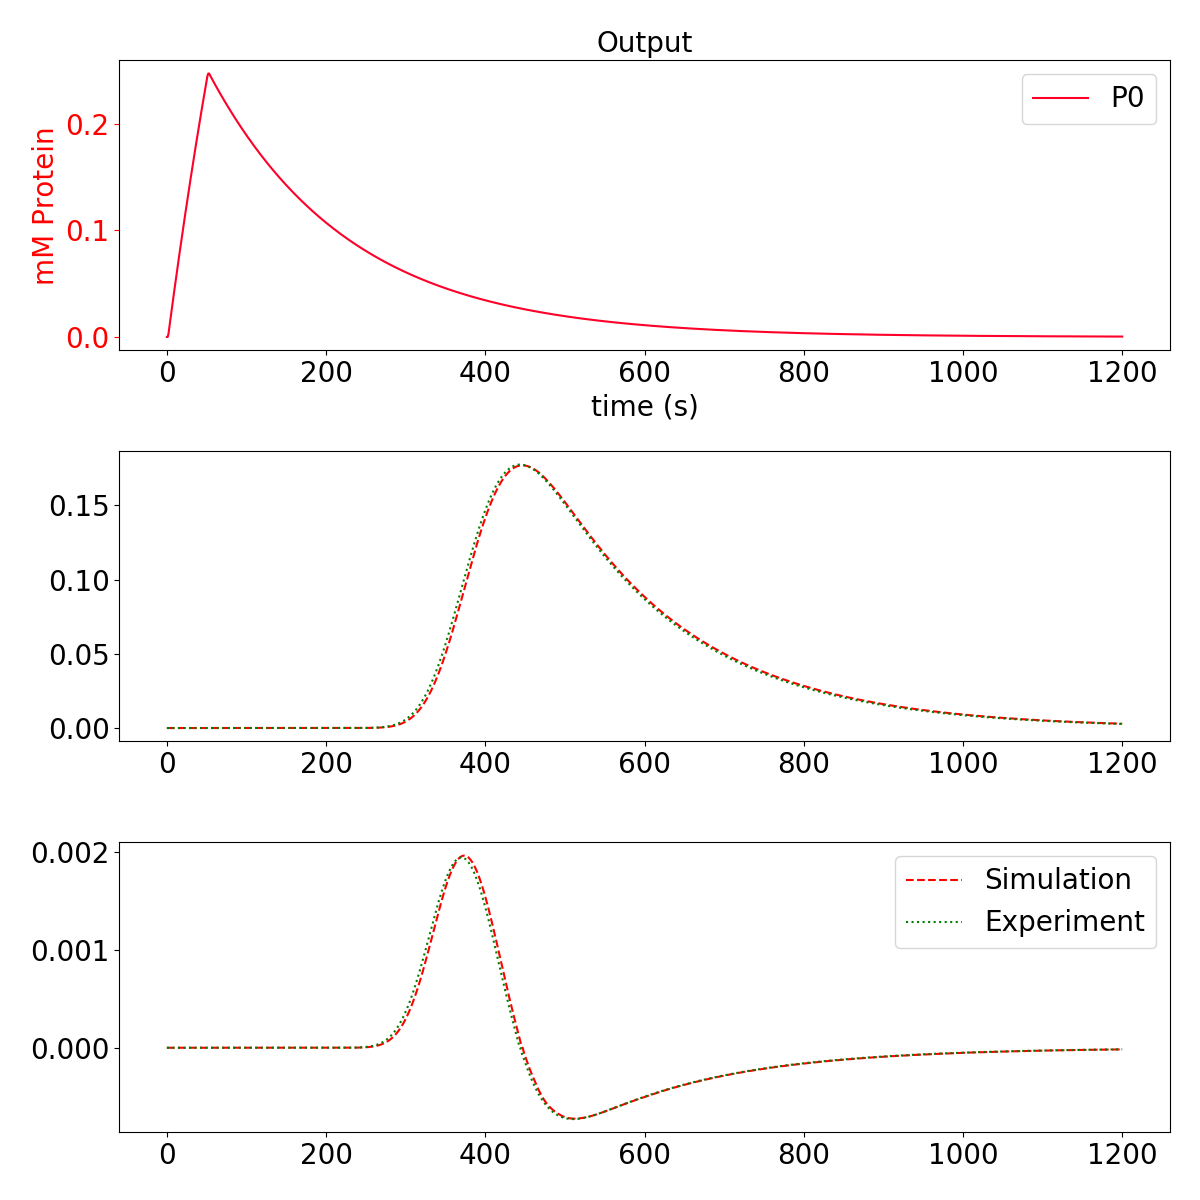

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.92e-05  true_value = 2.00e-05 error: 4.2%
INIT_VOLUME Comp:-1 Bound:-1 = 5.07e-06  true_value = 5.00e-06 error: 1.3%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.92e-05  true_value = 2.00e-05 error: 4.2%
INIT_VOLUME Comp:-1 Bound:-1 = 5.07e-06  true_value = 5.00e-06 error: 1.3%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.92e-05  true_value = 2.00e-05 error: 4.2%
INIT_VOLUME Comp:-1 Bound:-1 = 5.07e-06  true_value = 5.00e-06 error: 1.3%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.92e-05  true_value = 2.00e-05 error: 4.2%
INIT_VOLUME Comp:-1 Bound:-1 = 5.07e-06  true_value = 5.00e-06 error: 1.3%




In [4]:
true_values0 = numpy.array([example0.root.input.model.unit_003.col_dispersion, 
                           example0.root.input.model.unit_001.init_volume,])
    
sim0 = run_match(match0,
                    match_file0,
                    true_values0,
                    delete=True)

## View results

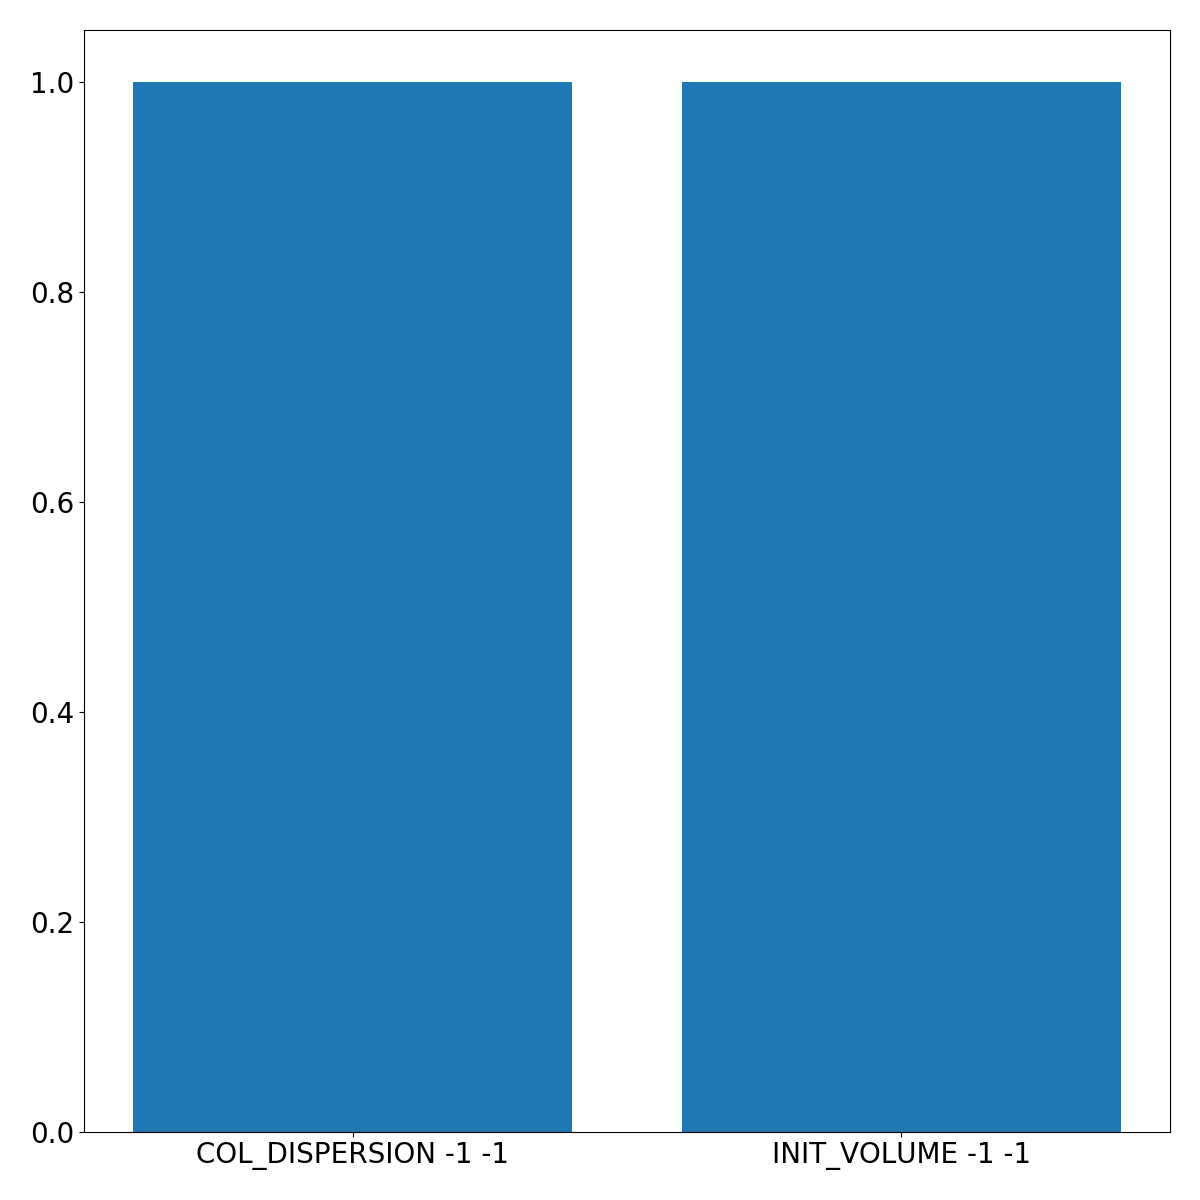

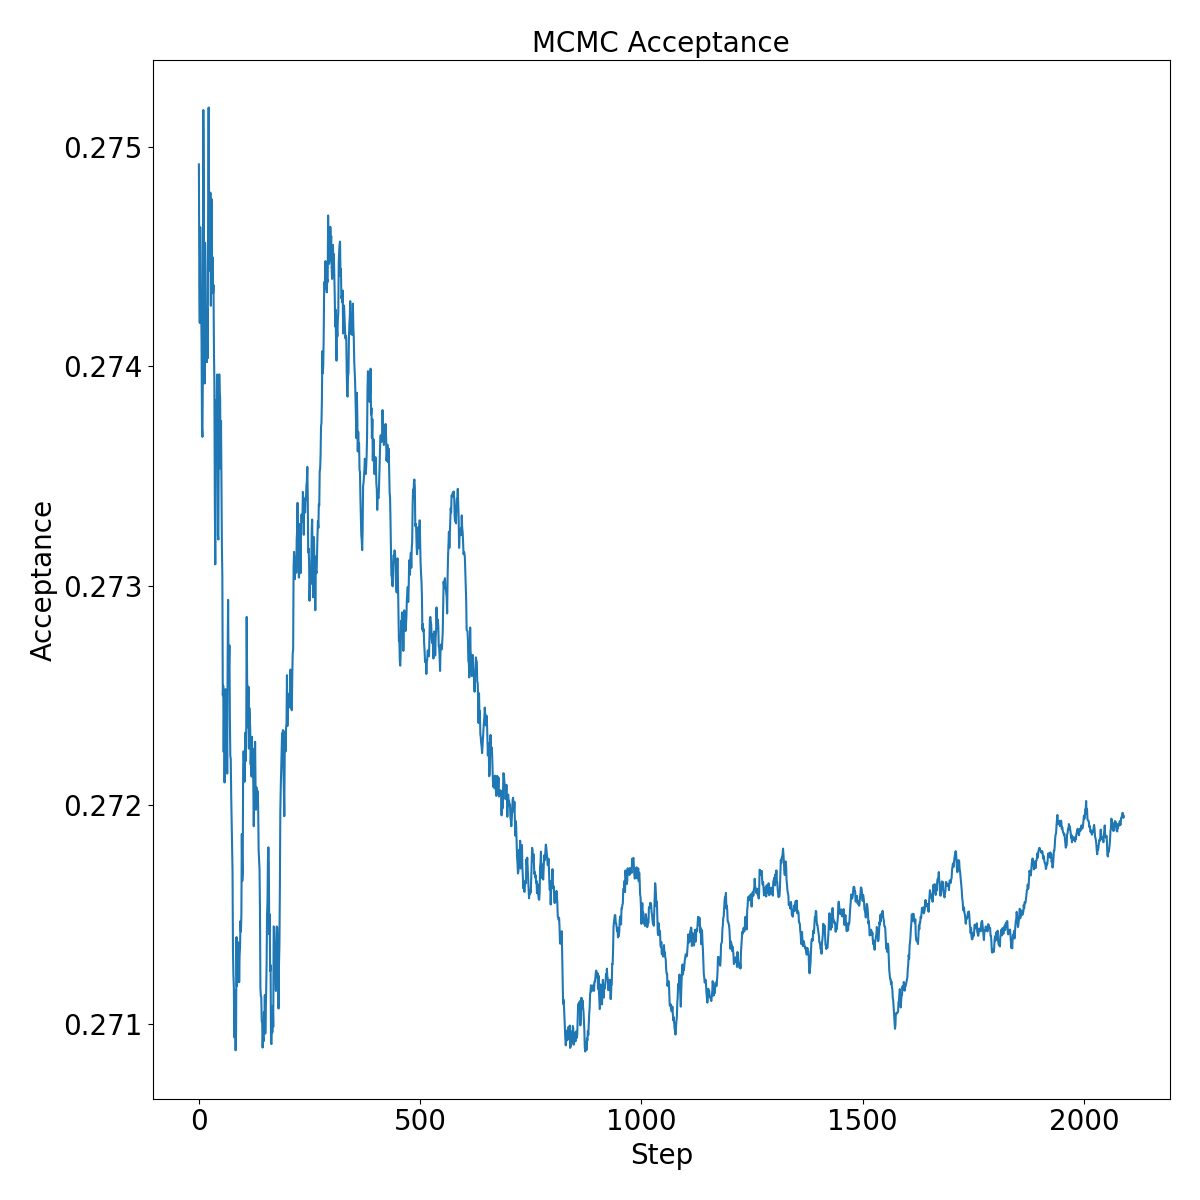

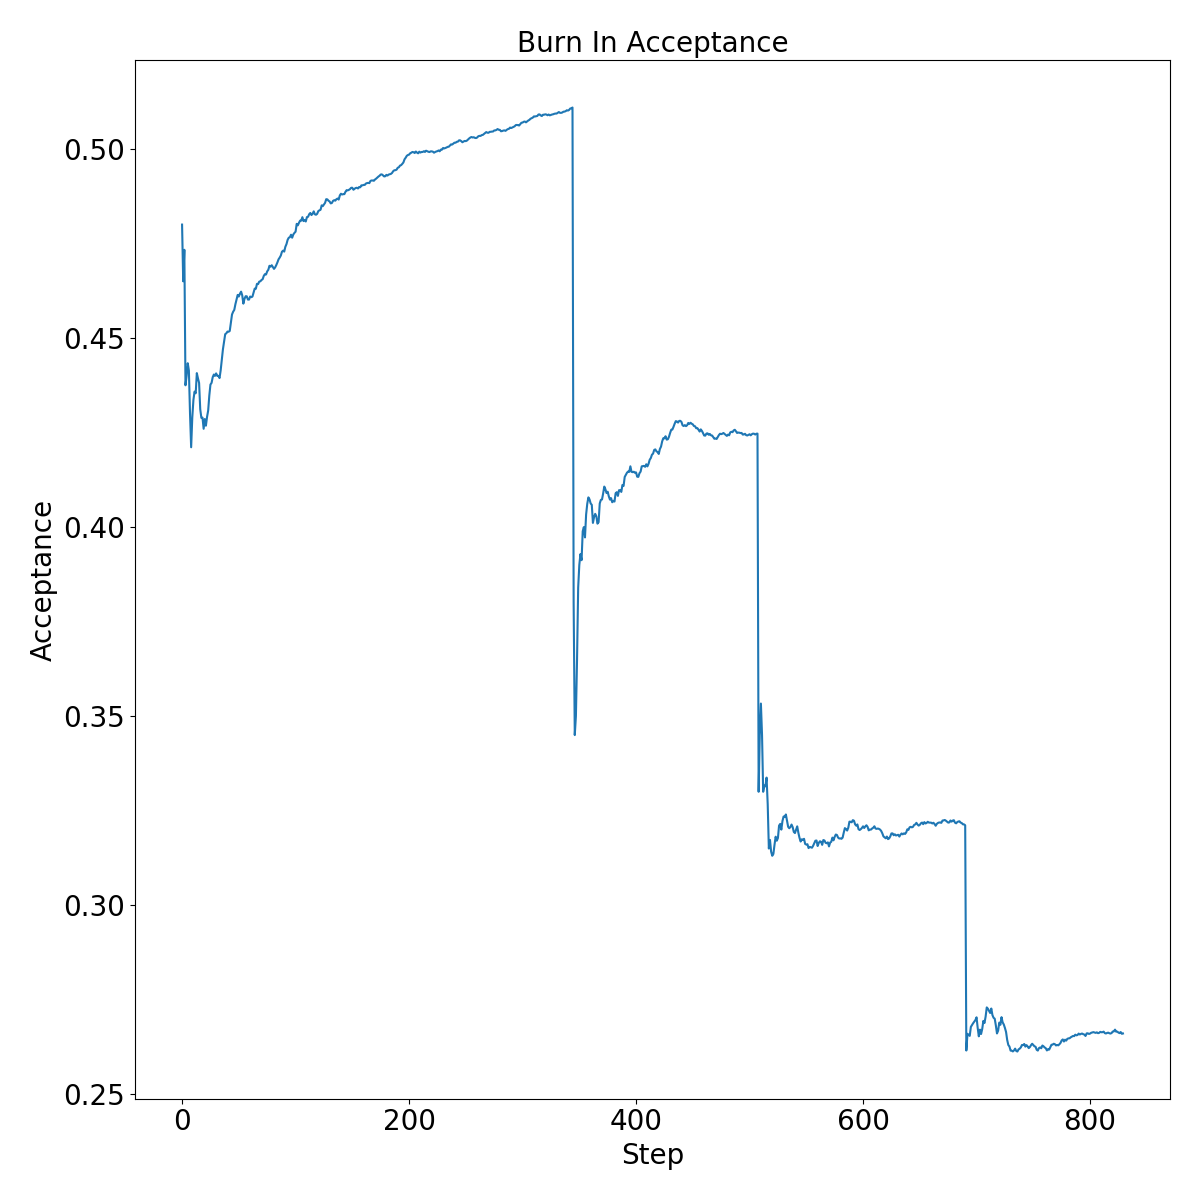

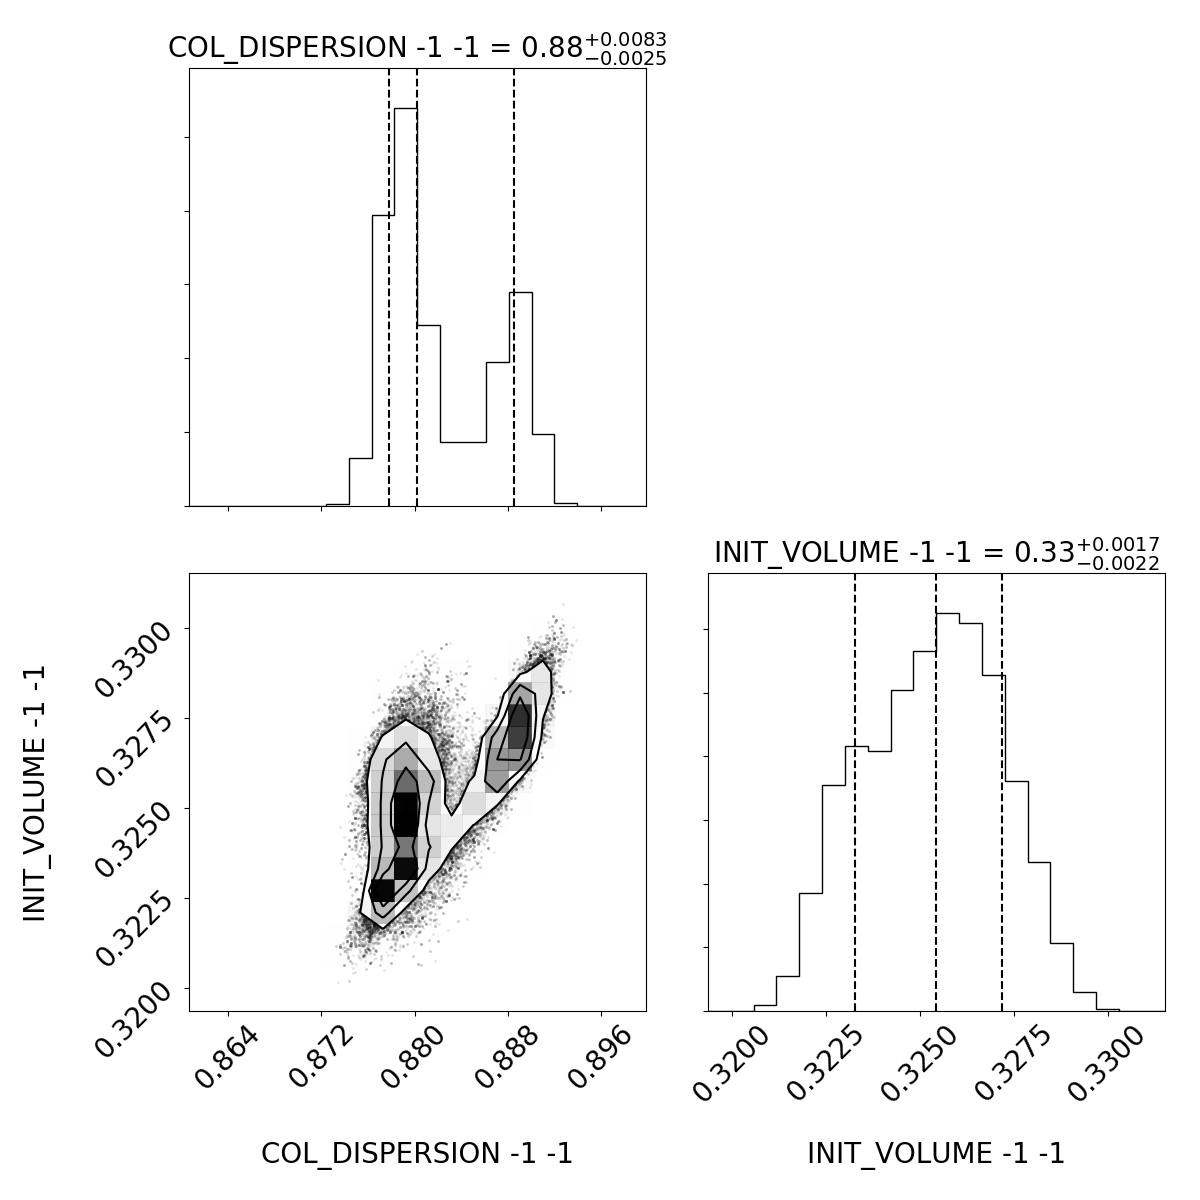

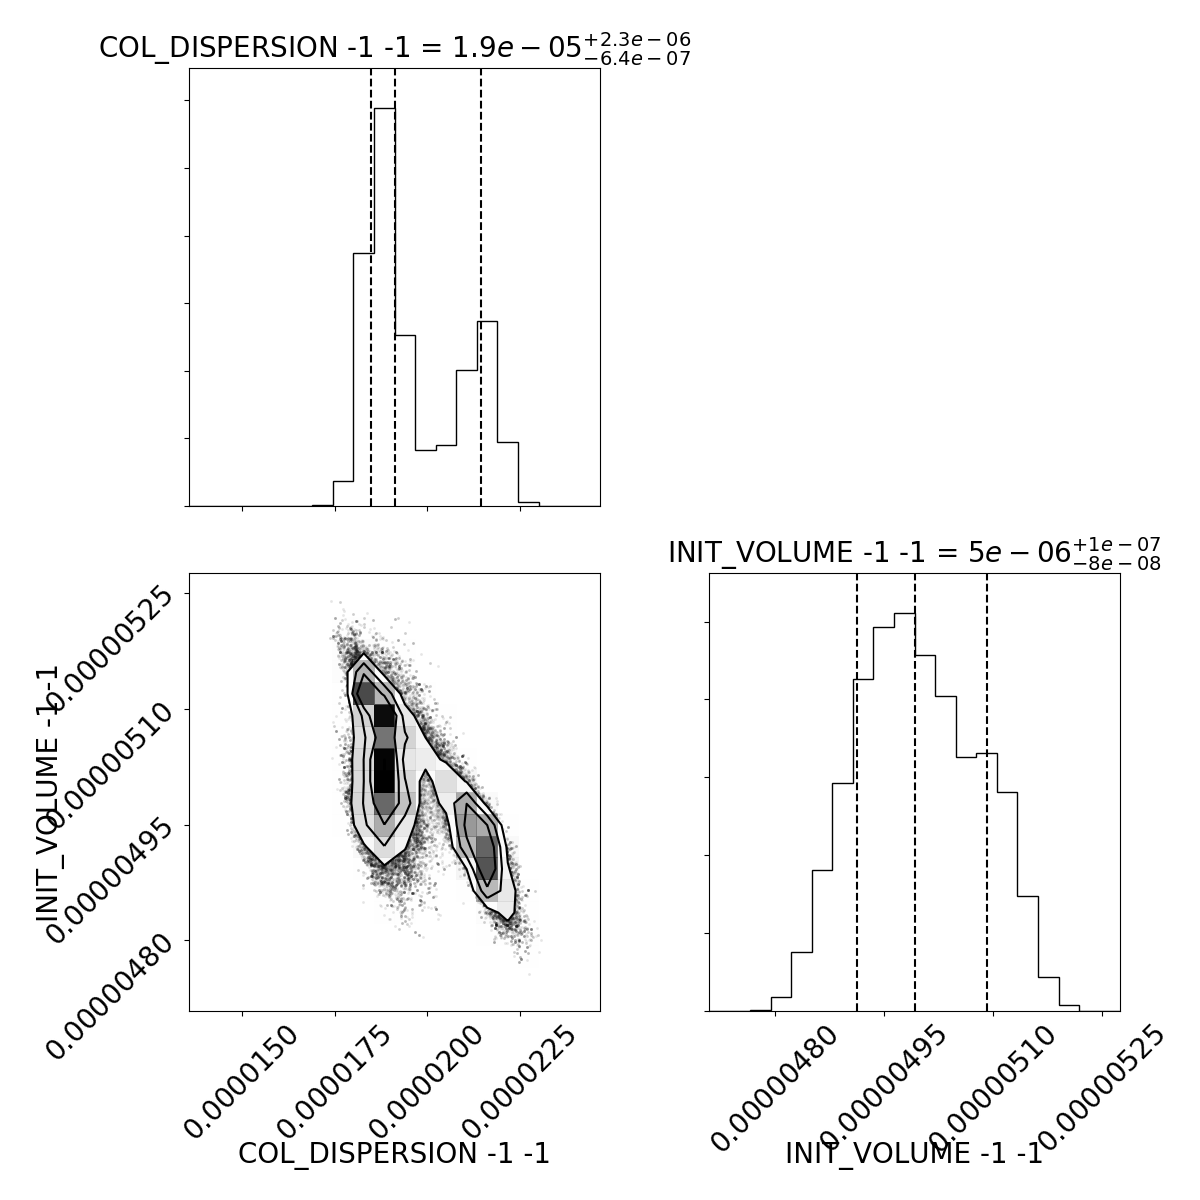

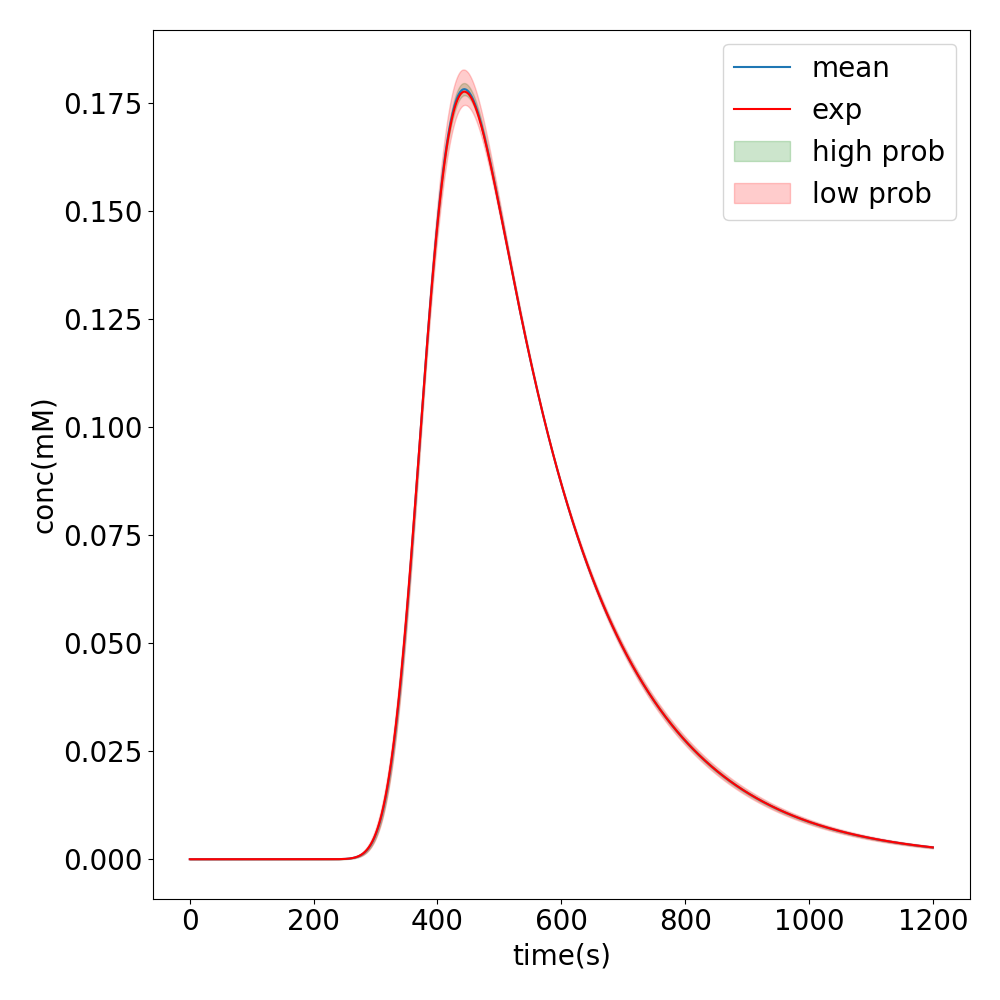

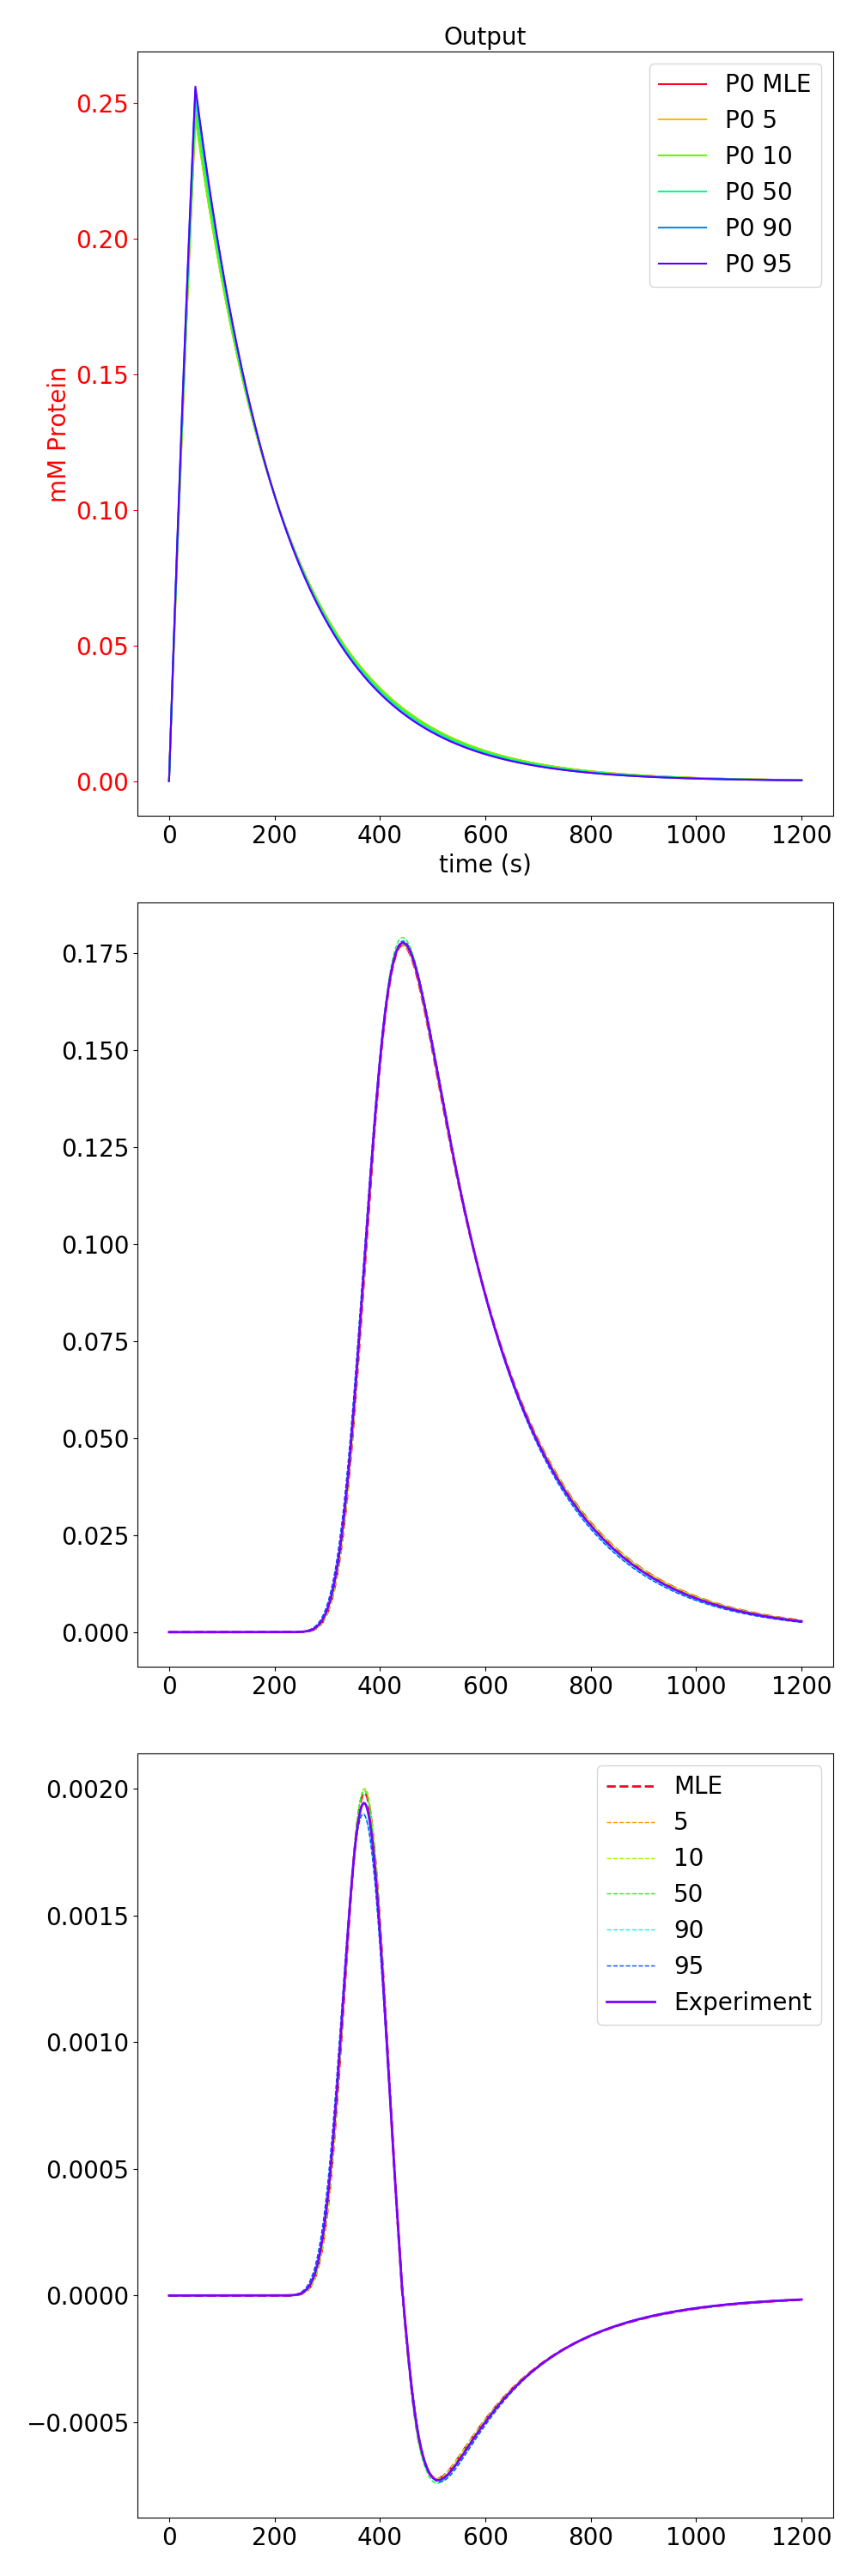

In [28]:
#look at the overall progress
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'tau_percent.png').as_posix() ))

#look at burn in process
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'mcmc_acceptance.png').as_posix() ))

#look at the acceptance
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'burn_in_acceptance.png').as_posix() ))

#look at the distributions in search space
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'full_corner.png').as_posix() ))

#look at the distributions in original space
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'full_corner_transform.png').as_posix() ))

#look at output distribution
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'space' / 'mcmc' / 'main_unit_002_0.png').as_posix() ))

#look at maximum likelihood
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'mcmc' / 'main_stats.png').as_posix() ))

## View stats

In [30]:
df = pandas.read_csv( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'mcmc' / 'prob.csv').as_posix() )
display(df.style.format({'COL_DISPERSION Comp:-1 Bound:-1':"{:.2g}" , 'INIT_VOLUME Comp:-1 Bound:-1': "{:.2g}"}))

print("Synthetic starting values")
print("Column dispersion %.2g" % true_values0[0])
print("CSTR volume %.2g" % true_values0[1])

,name,COL_DISPERSION Comp:-1 Bound:-1,INIT_VOLUME Comp:-1 Bound:-1
0,MLE,1.9e-05,5.1e-06
1,5,1.8e-05,5.1e-06
2,10,1.8e-05,5.1e-06
3,50,1.9e-05,5e-06
4,90,2.2e-05,4.9e-06
5,95,2.2e-05,4.9e-06


Synthetic starting values
Column dispersion 2e-05
CSTR volume 5e-06


# Create Dextran experiment

We can now carry forward with a Dextran pulse through the column and take into account the error already accounted for in the bypass experiment.

For this we will use the same experiment but this time we won't remove the column.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


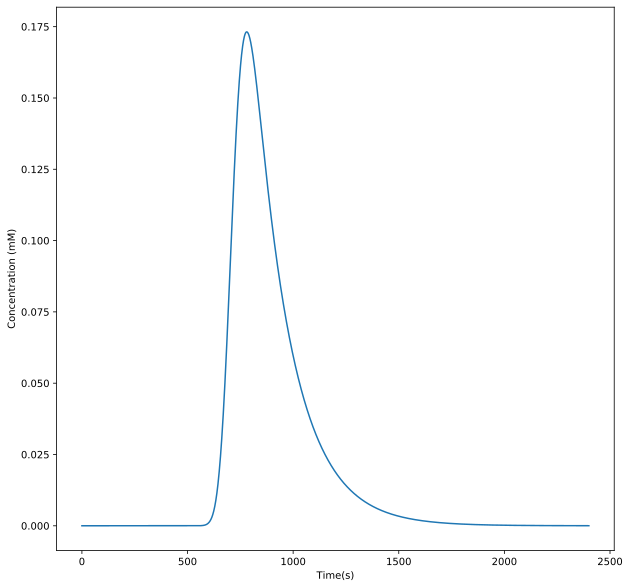

In [38]:
example_dir_1 = lesson_9 / "example_1"
example_dir_1.mkdir(exist_ok = True, parents=True)

example1 = Cadet()

#give a filename for where the simulation should be saved
example1.filename = (lesson_3 / "example_2" / 'example.h5').as_posix()

example1.load()

example1.filename = (example_dir_1 / 'example.h5').as_posix()

#change unit_001 parameters for a dextran pulse experiment

example1.root.input.model.unit_001.adsorption_model = 'NONE'
del example1.root.input.model.unit_001.adsorption

example1.root.input.model.unit_001.init_c = [0.0,]
example1.root.input.model.unit_001.init_q = [0.0,]
example1.root.input.model.unit_001.discretization.nbound = [0,]
example1.root.input.model.unit_001.film_diffusion = [0.0,]


#lower components to 1
example1.root.input.model.unit_001.ncomp = 1
example1.root.input.model.unit_002.ncomp = 1
example1.root.input.model.unit_003.ncomp = 1
example1.root.input.model.unit_004.ncomp = 1
example1.root.input.model.unit_005.ncomp = 1

example1.root.input.model.unit_003.discretization.nbound = [0,]
example1.root.input.model.unit_004.discretization.nbound = [0,]

#change the inlet to 1 component
#change the inlet
example1.root.input.model.unit_000.ncomp = 1

example1.root.input.model.unit_000.sec_000.const_coeff = [1.0,]
example1.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
example1.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
example1.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

example1.root.input.model.unit_000.sec_001.const_coeff = [0.0,]
example1.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]
example1.root.input.model.unit_000.sec_001.quad_coeff = [0.0,]
example1.root.input.model.unit_000.sec_001.cube_coeff = [0.0,]

del example1.root.input.model.unit_000.sec_002

#change the sections and section times

#solver settings
example1.root.input.solver.sections.section_times = [0.0, 50, 2400]

#set the times that the simulator writes out data for
example1.root.input.solver.user_solution_times = numpy.linspace(0, example1.root.input.solver.sections.section_times[-1], 
                                                               int(example1.root.input.solver.sections.section_times[-1]) + 1)

example1.root.input.solver.sections.nsec = len(example1.root.input.solver.sections.section_times) - 1


#save the simulation
example1.save()

#run the simulation
data = example1.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example1.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example1.root.output.solution.solution_times,
                        example1.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_1 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file

This configuration file is almost the same as before. The only complication is we have to include the previous mcmc results to use in this estimation.

In [50]:
match1 = Dict()
match1.CADETPath = cadet_path.as_posix()
match1.baseDir = example_dir_1.as_posix()
match1.resultsDir = 'fit_mcmc'
match1.csv = 'fit_results.csv'
match1.checkpointFile = "check"
match1.searchMethod = 'NSGA3'
match1.population = 50
match1.finalGradRefinement = 0
match1.stallGenerations = 10
match1.continueMCMC = 1
match1.tempDir = 'L:/'

#This is important, there is where we tell the system how to find the previous probability information
match1.mcmc_h5 = (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'mcmc' / 'mcmc.h5').as_posix()

error_model = Dict()
error_model.file_path = "example.h5"
error_model.experimental_csv = "example.csv"
error_model.name = "main"
error_model.units = [2,]
error_model.delay = [0.0, 3.0]
error_model.flow = [1.0, 0.03]
error_model.load = [1.0, 0.03]
error_model.error_slope = [1.0, 0.001]
error_model.error_base = 50.0
error_model.base = 50.0
error_model.count = 1000

match1.kde_synthetic = [error_model,]


#add the previous parameters to the estimation
parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_003/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-4

parameter2 = Dict()
parameter2.transform = 'set_value'
parameter2.componentFrom = -1
parameter2.boundFrom = -1
parameter2.locationFrom = "/input/model/unit_003/COL_DISPERSION"
parameter2.componentTo = -1
parameter2.boundTo = -1
parameter2.locationTo = "/input/model/unit_004/COL_DISPERSION"

parameter3 = Dict()
parameter3.transform = 'norm_log'
parameter3.component = -1
parameter3.bound = -1
parameter3.location = "/input/model/unit_001/INIT_VOLUME"
parameter3.min = 1e-4
parameter3.max = 1e-8

match1.parameters_mcmc = [parameter1, parameter2, parameter3]

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-4

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.1
parameter2.max = 0.9

match1.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

mle_dispersion = df.values[0, 1]
mle_volume = df.values[0, 2]

experiment1.set_values = [
                ["/input/model/unit_003/COL_DISPERSION", -1, mle_dispersion],
                ["/input/model/unit_004/COL_DISPERSION", -1, mle_dispersion],
                ["/input/model/unit_005/INIT_VOLUME", -1, mle_volume]
                ]

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'ShapeDecay'

experiment1.features = [feature1,]

match1.experiments = [experiment1,]

match_file1 = example_dir_1 / 'example_bypass.json'

with (match_file1).open('w') as json_file:
    json.dump(match1.to_dict(), json_file, indent='\t')

## Run match

In [ ]:
true_values1 = numpy.array([example1.root.input.model.unit_001.col_dispersion, 
                           example1.root.input.model.unit_001.col_porosity,
                            example1.root.input.model.unit_003.col_dispersion, 
                           example1.root.input.model.unit_005.init_volume,])
    
sim1 = run_match(match1,
                    match_file1,
                    true_values1,
                    delete=True)

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc 


[2019-10-20 20:19:50,532] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 20:19:50,533] launcher  INFO    Deploying 6 worker(s) over 1 host(s).

[2019-10-20 20:19:50,533] launcher  INFO    Worker distribution: 

[2019-10-20 20:19:50,533] launcher  INFO       127.0.0.1:	5 + origin

[2019-10-20 20:20:04,501] util      (b'127.0.0.1:64269') INFO    example.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:20:04,906] match     (b'127.0.0.1:64269') INFO    simulation took 0.4048333168029785

[2019-10-20 20:20:04,933] match     (b'127.0.0.1:64269') INFO    create bias template for experiment main

[2019-10-20 20:20:05,584] gradFD    (b'127.0.0.1:64269') INFO    grad simulation took 0.575002908706665

[2019-10-20 20:20:05,585] gradFD    (b'127.0.0.1:64269') INFO    grad C:/Users/ko

[2019-10-20 20:26:07,219] match     (b'127.0.0.1:64269') INFO    simulation took 0.43097448348999023

[2019-10-20 20:26:07,248] loggerwriter (b'127.0.0.1:64269') WARNING C:\Users\kosh_000\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

  RuntimeWarning)



[2019-10-20 20:26:07,248] loggerwriter (b'127.0.0.1:64269') WARNING C:\Users\kosh_000\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

  RuntimeWarning)



[2019-10-20 20:26:07,248] loggerwriter (b'127.0.0.1:64269') WARNING C:\Users\kosh_000\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMaxMeta' has already been created and it will be overwritten. Consider deleting previous cr

[2019-10-20 20:26:07,579] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:07,579] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:07,594] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:07,594] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:07,604] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:08,109] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:26:12,973] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:13,015] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:13,103] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:13,107] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:13,108] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:13,504] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:26:17,937] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:17,946] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:18,247] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:18,276] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:18,367] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:18,457] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 20:26:22,768] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:22,923] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:22,962] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:23,055] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:23,163] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:23,166] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 20:26:27,216] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:27,318] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:27,355] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:27,532] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:27,584] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:27,693] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:26:31,767] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:31,839] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:32,067] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:32,196] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:32,201] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:32,267] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:26:36,314] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:36,345] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:36,449] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:36,614] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:36,620] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:36,726] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:26:40,824] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:40,867] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:40,942] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:41,205] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:41,227] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:41,310] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 20:26:45,514] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:45,554] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:45,764] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:45,769] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:45,924] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:45,947] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 20:26:49,942] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:50,026] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:50,213] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:50,361] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:50,381] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:50,486] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:26:54,625] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:54,781] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:54,820] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:54,920] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:54,930] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:55,031] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:26:59,483] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:59,557] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:59,716] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:59,719] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:59,785] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:26:59,829] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:04,856] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:04,998] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:05,023] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:05,155] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:05,207] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:05,293] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:10,422] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:10,598] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:10,634] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:10,723] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:10,883] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:11,102] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:15,967] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:16,116] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:16,390] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:16,412] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:16,445] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:16,480] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:21,373] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:21,426] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:21,517] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:21,526] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:21,529] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:21,682] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/les


[2019-10-20 20:27:26,230] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:26,252] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:26,273] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:26,277] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:26,409] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:26,425] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/le

[2019-10-20 20:27:30,537] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:30,929] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:30,930] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:30,963] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:31,038] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:31,093] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:35,440] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:35,454] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:35,547] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:35,766] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:35,849] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:35,971] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:40,390] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:40,483] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:40,579] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:40,716] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:40,831] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:40,851] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:45,331] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:45,380] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:45,424] util      (b'127.0.0.1:64269') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:45,475] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:45,738] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:45,833] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:27:50,547] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:50,636] util      (b'127.0.0.1:56202') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:50,725] util      (b'127.0.0.1:61117') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:50,781] util      (b'127.0.0.1:59435') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:50,938] util      (b'127.0.0.1:51550') INFO    C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/fit_mcmc/misc/best_main_base.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-20 20:27:51,158] util      (b'127.0.0.1:53969') INFO    C:/Users/kosh_000/CADET/lessons/les

[2019-10-20 20:41:21,919] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 34 accept: 0.467 std: 0.0223 mean: 0.442 converge: 44.6

[2019-10-20 20:41:42,424] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 35 accept: 0.468 std: 0.0224 mean: 0.443 converge: 44.8

[2019-10-20 20:42:03,334] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 36 accept: 0.47 std: 0.0225 mean: 0.444 converge: 45.1

[2019-10-20 20:42:23,798] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 37 accept: 0.472 std: 0.0227 mean: 0.444 converge: 45.4

[2019-10-20 20:42:44,167] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 38 accept: 0.475 std: 0.0229 mean: 0.445 converge: 45.8

[2019-10-20 20:43:04,641] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 39 accept: 0.476 std: 0.0231 mean: 0.446 converge: 46.3

[2019-10-20 20:43:29,467] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 40 accept: 0.477 std: 0.0234 mean: 0.447 converge: 46.7

[2019-10-20 20:43:49,927] mcmc      (b'127.0.0.1:64269') INFO  

[2019-10-20 20:58:33,011] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 82 accept: 0.473 std: 0.00328 mean: 0.476 converge: 6.56

[2019-10-20 20:58:53,779] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 83 accept: 0.472 std: 0.00304 mean: 0.476 converge: 6.08

[2019-10-20 20:59:14,698] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 84 accept: 0.471 std: 0.00284 mean: 0.476 converge: 5.69

[2019-10-20 20:59:35,277] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 85 accept: 0.47 std: 0.00273 mean: 0.476 converge: 5.45

[2019-10-20 20:59:56,003] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 86 accept: 0.47 std: 0.00273 mean: 0.476 converge: 5.47

[2019-10-20 21:00:16,337] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 87 accept: 0.469 std: 0.00285 mean: 0.476 converge: 5.71

[2019-10-20 21:00:37,304] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 88 accept: 0.469 std: 0.00302 mean: 0.476 converge: 6.05

[2019-10-20 21:01:11,091] launcher  INFO    SCOOP 0.7 1.1

[2019-10-20 21:14:19,503] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 124 accept: 0.461 std: 0.00394 mean: 0.468 converge: 7.88

[2019-10-20 21:14:39,999] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 125 accept: 0.461 std: 0.00392 mean: 0.467 converge: 7.83

[2019-10-20 21:15:00,601] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 126 accept: 0.46 std: 0.00391 mean: 0.467 converge: 7.81

[2019-10-20 21:15:21,609] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 127 accept: 0.46 std: 0.00391 mean: 0.467 converge: 7.82

[2019-10-20 21:15:42,064] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 128 accept: 0.459 std: 0.00394 mean: 0.467 converge: 7.88

[2019-10-20 21:16:02,868] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 129 accept: 0.459 std: 0.00395 mean: 0.466 converge: 7.9

[2019-10-20 21:16:24,021] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 130 accept: 0.458 std: 0.00396 mean: 0.466 converge: 7.91

[2019-10-20 21:16:45,007] mcmc      (b'127.0.0.1:64

[2019-10-20 21:28:42,822] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 160 accept: 0.451 std: 0.00418 mean: 0.457 converge: 8.37

[2019-10-20 21:29:03,198] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 161 accept: 0.451 std: 0.00417 mean: 0.457 converge: 8.34

[2019-10-20 21:29:24,021] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 162 accept: 0.451 std: 0.00415 mean: 0.457 converge: 8.29

[2019-10-20 21:29:44,186] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 163 accept: 0.45 std: 0.00412 mean: 0.457 converge: 8.25

[2019-10-20 21:30:04,659] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 164 accept: 0.45 std: 0.00409 mean: 0.456 converge: 8.18

[2019-10-20 21:30:25,090] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 165 accept: 0.45 std: 0.00407 mean: 0.456 converge: 8.13

[2019-10-20 21:30:45,383] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 166 accept: 0.45 std: 0.00403 mean: 0.456 converge: 8.06

[2019-10-20 21:31:05,903] mcmc      (b'127.0.0.1:642

[2019-10-20 21:48:13,464] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 215 accept: 0.438 std: 0.00402 mean: 0.444 converge: 8.04

[2019-10-20 21:48:25,620] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 21:48:25,620] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-20 21:48:25,620] launcher  INFO    Worker distribution: 

[2019-10-20 21:48:25,620] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-20 21:48:39,825] generate_corner_graphs (b'127.0.0.1:53479') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-20 21:48:39,825] generate_corner_graphs (b'127.0.0.1:53479') INFO    plotting corner plots

[2019-10-20 21:48:39,837] generate_corner_graphs (b'127.0.0.1:53479') INFO    plot burn in acceptance

[2019-10-20 21:48:39,970] generate_corner_graphs (b'127.0.0.1:53479') INFO    plotting chain

[2019-10-2

[2019-10-20 22:04:13,951] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 257 accept: 0.428 std: 0.00356 mean: 0.433 converge: 7.11

[2019-10-20 22:04:34,498] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 258 accept: 0.427 std: 0.00357 mean: 0.433 converge: 7.14

[2019-10-20 22:04:55,894] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 259 accept: 0.427 std: 0.00358 mean: 0.433 converge: 7.16

[2019-10-20 22:05:16,527] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 260 accept: 0.427 std: 0.00359 mean: 0.433 converge: 7.18

[2019-10-20 22:05:37,558] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 261 accept: 0.427 std: 0.0036 mean: 0.433 converge: 7.2

[2019-10-20 22:05:58,242] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 262 accept: 0.427 std: 0.00361 mean: 0.432 converge: 7.21

[2019-10-20 22:06:19,946] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 263 accept: 0.427 std: 0.0036 mean: 0.432 converge: 7.21

[2019-10-20 22:06:42,379] mcmc      (b'127.0.0.1:64

[2019-10-20 22:21:52,773] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 304 accept: 0.417 std: 0.00315 mean: 0.423 converge: 6.3

[2019-10-20 22:22:14,942] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 305 accept: 0.417 std: 0.00318 mean: 0.423 converge: 6.36

[2019-10-20 22:22:37,115] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 306 accept: 0.417 std: 0.00321 mean: 0.423 converge: 6.42

[2019-10-20 22:22:59,008] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 307 accept: 0.416 std: 0.00324 mean: 0.422 converge: 6.48

[2019-10-20 22:23:33,782] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-20 22:23:33,782] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-20 22:23:33,782] launcher  INFO    Worker distribution: 

[2019-10-20 22:23:33,782] launcher  INFO       127.0.0.1:	3 + origin

[2019-10-20 22:23:48,035] generate_graphs (b'127.0

[2019-10-20 22:37:11,191] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 340 accept: 0.409 std: 0.00319 mean: 0.415 converge: 6.38

[2019-10-20 22:37:36,575] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 341 accept: 0.409 std: 0.00317 mean: 0.415 converge: 6.35

[2019-10-20 22:37:57,418] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 342 accept: 0.409 std: 0.00315 mean: 0.414 converge: 6.29

[2019-10-20 22:38:17,910] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 343 accept: 0.409 std: 0.00312 mean: 0.414 converge: 6.24

[2019-10-20 22:38:39,165] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 344 accept: 0.409 std: 0.0031 mean: 0.414 converge: 6.21

[2019-10-20 22:39:00,435] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 345 accept: 0.409 std: 0.00309 mean: 0.414 converge: 6.18

[2019-10-20 22:39:22,646] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 346 accept: 0.409 std: 0.00307 mean: 0.413 converge: 6.15

[2019-10-20 22:39:43,668] mcmc      (b'127.0.0.1:

[2019-10-20 22:53:34,365] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 382 accept: 0.402 std: 0.00253 mean: 0.406 converge: 5.06

[2019-10-20 22:53:57,025] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 383 accept: 0.402 std: 0.00252 mean: 0.406 converge: 5.04

[2019-10-20 22:54:18,954] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 384 accept: 0.402 std: 0.00252 mean: 0.406 converge: 5.04

[2019-10-20 22:54:40,010] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 385 accept: 0.402 std: 0.00251 mean: 0.406 converge: 5.02

[2019-10-20 22:55:00,739] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 386 accept: 0.402 std: 0.0025 mean: 0.406 converge: 5

[2019-10-20 22:55:20,433] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 387 accept: 0.401 std: 0.0025 mean: 0.406 converge: 5.01

[2019-10-20 22:55:39,712] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 388 accept: 0.401 std: 0.00251 mean: 0.405 converge: 5.02

[2019-10-20 22:55:58,581] mcmc      (b'127.0.0.1:6426

[2019-10-20 23:10:47,322] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 0

[2019-10-20 23:10:47,460] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 0

[2019-10-20 23:10:47,601] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 1

[2019-10-20 23:10:47,732] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 1

[2019-10-20 23:10:47,871] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 2

[2019-10-20 23:10:48,016] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 2

[2019-10-20 23:10:48,156] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 3

[2019-10-20 23:10:48,297] generate_corner_graphs (b'127.0.0.1:60455') INFO    plotting mcmc param 3

[2019-10-20 23:10:48,947] launcher  (127.0.0.1:53617) INFO    Root process is done.

[2019-10-20 23:10:48,948] launcher  (127.0.0.1:53617) INFO    Finished cleaning spawned subprocesses.

[201

[2019-10-20 23:27:37,320] generate_graphs (b'127.0.0.1:55519') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-20 23:28:29,477] launcher  (127.0.0.1:54151) INFO    Root process is done.

[2019-10-20 23:28:29,477] launcher  (127.0.0.1:54151) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 23:28:29,550] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 478 accept: 0.389 std: 0.00197 mean: 0.392 converge: 3.93

[2019-10-20 23:28:51,956] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 479 accept: 0.389 std: 0.00197 mean: 0.392 converge: 3.94

[2019-10-20 23:29:14,609] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 480 accept: 0.389 std: 0.00198 mean: 0.392 converge: 3.96

[2019-10-20 23:29:37,135] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 481 accept: 0.388 std: 0.00198 mean: 0.392 converge: 3.97

[2019-10-20 23:29:59,880] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 482 accept: 0.388 std: 0.00199 mean: 0.391 conver

[2019-10-20 23:44:25,181] generate_graphs (b'127.0.0.1:56073') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-20 23:44:26,744] launcher  (127.0.0.1:54546) INFO    Root process is done.

[2019-10-20 23:44:26,744] launcher  (127.0.0.1:54546) INFO    Finished cleaning spawned subprocesses.

[2019-10-20 23:44:37,971] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 521 accept: 0.384 std: 0.00152 mean: 0.387 converge: 3.04

[2019-10-20 23:45:00,211] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 522 accept: 0.384 std: 0.00152 mean: 0.387 converge: 3.03

[2019-10-20 23:45:22,856] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 523 accept: 0.384 std: 0.00151 mean: 0.387 converge: 3.03

[2019-10-20 23:45:45,488] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 524 accept: 0.384 std: 0.00151 mean: 0.386 converge: 3.02

[2019-10-20 23:46:08,019] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 525 accept: 0.384 std: 0.0015 mean: 0.386 converg

[2019-10-21 00:01:30,442] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 566 accept: 0.38 std: 0.00131 mean: 0.382 converge: 2.63

[2019-10-21 00:01:52,515] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 567 accept: 0.38 std: 0.00131 mean: 0.382 converge: 2.61

[2019-10-21 00:02:14,728] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 568 accept: 0.38 std: 0.0013 mean: 0.382 converge: 2.6

[2019-10-21 00:02:35,772] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 569 accept: 0.38 std: 0.0013 mean: 0.382 converge: 2.6

[2019-10-21 00:02:56,503] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 570 accept: 0.38 std: 0.0013 mean: 0.382 converge: 2.6

[2019-10-21 00:03:17,632] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 571 accept: 0.38 std: 0.0013 mean: 0.382 converge: 2.61

[2019-10-21 00:03:38,828] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 572 accept: 0.38 std: 0.0013 mean: 0.382 converge: 2.61

[2019-10-21 00:04:00,172] mcmc      (b'127.0.0.1:64269') INFO  

[2019-10-21 00:17:23,783] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 608 accept: 0.376 std: 0.00149 mean: 0.378 converge: 2.97

[2019-10-21 00:17:45,037] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 609 accept: 0.376 std: 0.00149 mean: 0.378 converge: 2.98

[2019-10-21 00:18:07,381] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 610 accept: 0.376 std: 0.00149 mean: 0.378 converge: 2.99

[2019-10-21 00:18:28,779] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 611 accept: 0.376 std: 0.0015 mean: 0.378 converge: 3

[2019-10-21 00:18:49,794] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 612 accept: 0.375 std: 0.0015 mean: 0.378 converge: 3

[2019-10-21 00:19:11,446] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 613 accept: 0.375 std: 0.0015 mean: 0.378 converge: 3

[2019-10-21 00:19:33,120] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 614 accept: 0.375 std: 0.0015 mean: 0.378 converge: 3

[2019-10-21 00:19:54,854] mcmc      (b'127.0.0.1:64269') INFO   

[2019-10-21 00:32:39,296] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 645 accept: 0.373 std: 0.00123 mean: 0.375 converge: 2.47

[2019-10-21 00:33:00,281] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 646 accept: 0.373 std: 0.00123 mean: 0.375 converge: 2.45

[2019-10-21 00:33:21,594] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 647 accept: 0.373 std: 0.00122 mean: 0.375 converge: 2.44

[2019-10-21 00:33:42,834] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 648 accept: 0.373 std: 0.00121 mean: 0.375 converge: 2.42

[2019-10-21 00:34:04,734] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 649 accept: 0.372 std: 0.0012 mean: 0.375 converge: 2.4

[2019-10-21 00:34:26,090] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 650 accept: 0.372 std: 0.0012 mean: 0.374 converge: 2.39

[2019-10-21 00:34:47,457] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 651 accept: 0.372 std: 0.00119 mean: 0.374 converge: 2.37

[2019-10-21 00:35:08,988] mcmc      (b'127.0.0.1:64

[2019-10-21 00:52:39,776] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-21 00:52:39,776] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-21 00:52:39,776] launcher  INFO    Worker distribution: 

[2019-10-21 00:52:39,776] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-21 00:52:42,950] generate_corner_graphs (b'127.0.0.1:52563') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-21 00:52:42,950] generate_corner_graphs (b'127.0.0.1:52563') INFO    plotting corner plots

[2019-10-21 00:52:42,966] generate_corner_graphs (b'127.0.0.1:52563') INFO    plot burn in acceptance

[2019-10-21 00:52:43,097] generate_corner_graphs (b'127.0.0.1:52563') INFO    plotting chain

[2019-10-21 00:52:45,825] generate_corner_graphs (b'127.0.0.1:52563') INFO    plotting mcmc param 0

[2019-10-21 00:52:45,959] generate_corner_gra

[2019-10-21 01:08:43,261] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 742 accept: 0.366 std: 0.000856 mean: 0.367 converge: 1.71

[2019-10-21 01:09:05,552] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 743 accept: 0.366 std: 0.00085 mean: 0.367 converge: 1.7

[2019-10-21 01:09:27,967] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 744 accept: 0.366 std: 0.000846 mean: 0.367 converge: 1.69

[2019-10-21 01:09:50,392] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 745 accept: 0.366 std: 0.000842 mean: 0.367 converge: 1.68

[2019-10-21 01:10:12,997] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 746 accept: 0.366 std: 0.000835 mean: 0.367 converge: 1.67

[2019-10-21 01:10:35,106] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 747 accept: 0.366 std: 0.000828 mean: 0.367 converge: 1.66

[2019-10-21 01:10:57,379] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 748 accept: 0.366 std: 0.000817 mean: 0.367 converge: 1.63

[2019-10-21 01:11:19,994] mcmc      (b'127.

[2019-10-21 01:25:18,283] generate_graphs (b'127.0.0.1:63207') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-21 01:25:20,130] launcher  (127.0.0.1:57245) INFO    Root process is done.

[2019-10-21 01:25:20,130] launcher  (127.0.0.1:57245) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 01:25:31,349] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 787 accept: 0.363 std: 0.000811 mean: 0.365 converge: 1.62

[2019-10-21 01:25:53,702] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 788 accept: 0.363 std: 0.000818 mean: 0.365 converge: 1.64

[2019-10-21 01:26:15,710] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 789 accept: 0.363 std: 0.000823 mean: 0.365 converge: 1.65

[2019-10-21 01:26:38,315] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 790 accept: 0.363 std: 0.000824 mean: 0.365 converge: 1.65

[2019-10-21 01:27:00,869] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 791 accept: 0.363 std: 0.000823 mean: 0.365 c

[2019-10-21 01:41:06,091] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 825 accept: 0.25 std: 0 mean: 0.25 converge: 0

[2019-10-21 01:41:29,264] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 826 accept: 0.24 std: 0.005 mean: 0.245 converge: 10

[2019-10-21 01:41:51,729] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 827 accept: 0.238 std: 0.00515 mean: 0.243 converge: 10.3

[2019-10-21 01:42:14,515] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 828 accept: 0.233 std: 0.0063 mean: 0.24 converge: 12.6

[2019-10-21 01:42:37,169] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 829 accept: 0.23 std: 0.00696 mean: 0.238 converge: 13.9

[2019-10-21 01:42:59,324] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 830 accept: 0.233 std: 0.0067 mean: 0.237 converge: 13.4

[2019-10-21 01:43:21,688] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 831 accept: 0.229 std: 0.00679 mean: 0.236 converge: 13.6

[2019-10-21 01:43:44,011] mcmc      (b'127.0.0.1:64269') INFO    bur

[2019-10-21 01:56:43,588] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 867 accept: 0.218 std: 0.00704 mean: 0.224 converge: 14.1

[2019-10-21 01:57:04,588] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 868 accept: 0.217 std: 0.00703 mean: 0.224 converge: 14.1

[2019-10-21 01:57:25,970] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 869 accept: 0.217 std: 0.00702 mean: 0.224 converge: 14

[2019-10-21 01:57:46,836] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 870 accept: 0.216 std: 0.00703 mean: 0.223 converge: 14.1

[2019-10-21 01:58:08,184] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 871 accept: 0.217 std: 0.00702 mean: 0.223 converge: 14

[2019-10-21 01:58:29,533] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 872 accept: 0.216 std: 0.00702 mean: 0.223 converge: 14

[2019-10-21 01:58:52,123] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 873 accept: 0.217 std: 0.00701 mean: 0.223 converge: 14

[2019-10-21 01:59:13,108] mcmc      (b'127.0.0.1:64269')

[2019-10-21 02:13:57,675] generate_corner_graphs (b'127.0.0.1:56178') INFO    plotting mcmc param 1

[2019-10-21 02:13:57,804] generate_corner_graphs (b'127.0.0.1:56178') INFO    plotting mcmc param 1

[2019-10-21 02:13:57,938] generate_corner_graphs (b'127.0.0.1:56178') INFO    plotting mcmc param 2

[2019-10-21 02:13:58,078] generate_corner_graphs (b'127.0.0.1:56178') INFO    plotting mcmc param 2

[2019-10-21 02:13:58,213] generate_corner_graphs (b'127.0.0.1:56178') INFO    plotting mcmc param 3

[2019-10-21 02:13:58,347] generate_corner_graphs (b'127.0.0.1:56178') INFO    plotting mcmc param 3

[2019-10-21 02:13:58,999] launcher  (127.0.0.1:58608) INFO    Root process is done.

[2019-10-21 02:13:59,000] launcher  (127.0.0.1:58608) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 02:14:20,274] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 915 accept: 0.221 std: 0.00157 mean: 0.219 converge: 3.15

[2019-10-21 02:14:41,904] mcmc      (b'127.0.0.1:64269') INFO    burn:

[2019-10-21 02:31:29,495] generate_graphs (b'127.0.0.1:53031') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-21 02:33:04,756] launcher  (127.0.0.1:59141) INFO    Root process is done.

[2019-10-21 02:33:04,757] launcher  (127.0.0.1:59141) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 02:33:15,795] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 963 accept: 0.222 std: 0.000696 mean: 0.221 converge: 1.39

[2019-10-21 02:33:36,964] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 964 accept: 0.222 std: 0.000698 mean: 0.221 converge: 1.4

[2019-10-21 02:33:58,179] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 965 accept: 0.222 std: 0.000706 mean: 0.221 converge: 1.41

[2019-10-21 02:34:19,365] mcmc      (b'127.0.0.1:64269') INFO    burn:  idx: 966 accept: 0.222 std: 0.000715 mean: 0.221 converge: 1.43

[2019-10-21 02:34:20,313] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default,

[2019-10-21 02:49:29,091] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 25 accept: 0.220

[2019-10-21 02:49:50,773] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 26 accept: 0.221

[2019-10-21 02:50:11,925] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 27 accept: 0.220

[2019-10-21 02:50:33,021] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 28 accept: 0.218

[2019-10-21 02:50:53,750] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 29 accept: 0.218

[2019-10-21 02:51:15,460] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 30 accept: 0.218

[2019-10-21 02:51:36,778] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 31 accept: 0.217

[2019-10-21 02:51:57,809] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 32 accept: 0.217

[2019-10-21 02:52:19,638] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 33 accept: 0.217

[2019-10-21 02:52:42,072] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 34 accept: 0.217

[2019-10-21 02:53:05,116] mcmc      (b'127.0.0.1:64269') INF

[2019-10-21 03:06:07,541] generate_graphs (b'127.0.0.1:53245') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-21 03:06:08,578] launcher  (127.0.0.1:60074) INFO    Root process is done.

[2019-10-21 03:06:08,578] launcher  (127.0.0.1:60074) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 03:06:20,593] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 71 accept: 0.219

[2019-10-21 03:06:41,497] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 72 accept: 0.219

[2019-10-21 03:07:02,114] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 73 accept: 0.218

[2019-10-21 03:07:24,938] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 74 accept: 0.219

[2019-10-21 03:07:24,983] mcmc      (b'127.0.0.1:64269') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 2;

tau: [7.30194657 7.28723381 7.08887109 7.45595783]

[2019-10-21 03:07:2

[2019-10-21 03:22:21,194] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 113 accept: 0.220

[2019-10-21 03:22:42,950] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 114 accept: 0.220

[2019-10-21 03:23:05,643] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 115 accept: 0.220

[2019-10-21 03:23:27,879] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 116 accept: 0.220

[2019-10-21 03:23:50,471] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 117 accept: 0.220

[2019-10-21 03:24:12,619] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 118 accept: 0.220

[2019-10-21 03:24:34,804] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 119 accept: 0.220

[2019-10-21 03:24:57,117] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 120 accept: 0.221

[2019-10-21 03:25:20,412] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 121 accept: 0.221

[2019-10-21 03:25:42,900] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 122 accept: 0.221

[2019-10-21 03:26:05,032] mcmc      (b'127.0.0.1:6

[2019-10-21 03:37:32,618] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 148 accept: 0.222

[2019-10-21 03:37:54,913] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 149 accept: 0.222

[2019-10-21 03:37:54,968] mcmc      (b'127.0.0.1:64269') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 3;

tau: [13.91354201 13.74298459 14.54121425 14.88043724]

[2019-10-21 03:37:54,968] mcmc      (b'127.0.0.1:64269') INFO    Mean acceptance fraction: 150 0.222 tau: [13.91354201 13.74298459 14.54121425 14.88043724]

[2019-10-21 03:38:17,443] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 150 accept: 0.221

[2019-10-21 03:38:39,808] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 151 accept: 0.222

[2019-10-21 03:39:02,166] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 152 accept: 0.221

[2019-10-21 03:39:25,000] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 153 accept: 0

[2019-10-21 03:55:44,749] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 157 accept: 0.221

[2019-10-21 03:56:06,866] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 158 accept: 0.221

[2019-10-21 03:56:07,812] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-21 03:56:07,812] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-21 03:56:07,812] launcher  INFO    Worker distribution: 

[2019-10-21 03:56:07,812] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-21 03:56:11,143] generate_corner_graphs (b'127.0.0.1:65195') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-21 03:56:11,144] generate_corner_graphs (b'127.0.0.1:65195') INFO    plotting corner plots

[2019-10-21 03:56:11,165] generate_corner_graphs (b'127.0.0.1:65195') INFO    plotting tau plots

[2019-10-21 03:56:11,286] generate_corner_graphs (b'127

[2019-10-21 04:13:02,467] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 203 accept: 0.221

[2019-10-21 04:13:24,678] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 204 accept: 0.221

[2019-10-21 04:13:46,495] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 205 accept: 0.221

[2019-10-21 04:14:08,889] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 206 accept: 0.221

[2019-10-21 04:14:30,868] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 207 accept: 0.221

[2019-10-21 04:14:53,351] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 208 accept: 0.221

[2019-10-21 04:15:15,615] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 209 accept: 0.221

[2019-10-21 04:15:38,912] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-21 04:15:38,912] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-21 04:15:38,912] launcher  INFO    Worker distribution: 

[2019-10-21 04:28:47,031] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 245 accept: 0.221

[2019-10-21 04:29:09,160] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 246 accept: 0.221

[2019-10-21 04:29:32,306] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 247 accept: 0.221

[2019-10-21 04:29:54,529] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 248 accept: 0.221

[2019-10-21 04:30:16,921] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 249 accept: 0.221

[2019-10-21 04:30:16,975] mcmc      (b'127.0.0.1:64269') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 5;

tau: [22.98327395 22.7674605  23.2770646  22.78939614]

[2019-10-21 04:30:16,976] mcmc      (b'127.0.0.1:64269') INFO    Mean acceptance fraction: 250 0.221 tau: [22.98327395 22.7674605  23.2770646  22.78939614]

[2019-10-21 04:30:39,938] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 250 accept: 0

[2019-10-21 04:42:17,641] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 275 accept: 0.221

[2019-10-21 04:42:39,818] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 276 accept: 0.221

[2019-10-21 04:43:02,209] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 277 accept: 0.221

[2019-10-21 04:43:24,620] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 278 accept: 0.221

[2019-10-21 04:43:46,711] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 279 accept: 0.221

[2019-10-21 04:44:08,698] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 280 accept: 0.221

[2019-10-21 04:44:30,911] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 281 accept: 0.221

[2019-10-21 04:44:53,037] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 282 accept: 0.221

[2019-10-21 04:45:15,567] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 283 accept: 0.221

[2019-10-21 04:45:37,678] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 284 accept: 0.221

[2019-10-21 04:45:59,873] mcmc      (b'127.0.0.1:6

[2019-10-21 05:01:33,670] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 30: f(x)= -12215.8

[2019-10-21 05:01:38,578] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 31: f(x)= -12215.8

[2019-10-21 05:01:43,468] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 32: f(x)= -12461.3

[2019-10-21 05:01:48,391] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 33: f(x)= -12461.3

[2019-10-21 05:01:53,626] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 34: f(x)= -12461.3

[2019-10-21 05:01:58,783] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 35: f(x)= -12461.3

[2019-10-21 05:02:03,620] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 36: f(x)= -12461.3

[2019-10-21 05:02:08,517] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 37: f(x)= -12461.3

[2019-10-21 05:02:13,794] loggerwriter (b'127.0.0.1:53403') INFO    diff

[2019-10-21 05:07:21,133] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 101: f(x)= -12472.1

[2019-10-21 05:07:26,017] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 102: f(x)= -12472.1

[2019-10-21 05:07:30,867] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 103: f(x)= -12472.1

[2019-10-21 05:07:36,310] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 104: f(x)= -12472.1

[2019-10-21 05:07:41,274] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 105: f(x)= -12472.1

[2019-10-21 05:07:46,240] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 106: f(x)= -12472.1

[2019-10-21 05:07:51,274] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 107: f(x)= -12472.1

[2019-10-21 05:07:56,258] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 108: f(x)= -12472.1

[2019-10-21 05:08:21,983] mle       (b'127.0.0.1:53403') INFO   

[2019-10-21 05:23:57,223] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 62: f(x)= -4.24228

[2019-10-21 05:24:12,473] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 63: f(x)= -4.24228

[2019-10-21 05:24:27,600] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 64: f(x)= -4.24228

[2019-10-21 05:24:42,723] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 65: f(x)= -4.24228

[2019-10-21 05:24:57,777] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 66: f(x)= -4.24228

[2019-10-21 05:25:13,323] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 67: f(x)= -4.24228

[2019-10-21 05:25:28,621] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 68: f(x)= -4.24228

[2019-10-21 05:25:43,703] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 69: f(x)= -4.24228

[2019-10-21 05:25:59,272] loggerwriter (b'127.0.0.1:53403') INFO    diff

[2019-10-21 05:41:00,063] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 133: f(x)= -4.69548

[2019-10-21 05:41:14,951] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 134: f(x)= -4.69548

[2019-10-21 05:41:30,297] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 135: f(x)= -4.69548

[2019-10-21 05:41:45,158] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 136: f(x)= -4.69548

[2019-10-21 05:41:58,937] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 137: f(x)= -4.69548

[2019-10-21 05:42:12,516] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 138: f(x)= -4.69548

[2019-10-21 05:42:26,291] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 139: f(x)= -4.69548

[2019-10-21 05:42:39,733] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 140: f(x)= -4.69548

[2019-10-21 05:42:53,104] loggerwriter (b'127.0.0.1:53403') INFO

[2019-10-21 05:58:05,877] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 204: f(x)= -4.69548

[2019-10-21 05:58:21,187] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 205: f(x)= -4.69548

[2019-10-21 05:58:35,978] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 206: f(x)= -4.69548

[2019-10-21 05:58:50,065] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 207: f(x)= -4.69548

[2019-10-21 05:59:04,011] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 208: f(x)= -4.69548

[2019-10-21 05:59:17,142] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 209: f(x)= -4.69548

[2019-10-21 05:59:30,653] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 210: f(x)= -4.69548

[2019-10-21 05:59:43,462] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 211: f(x)= -4.69548

[2019-10-21 05:59:56,404] loggerwriter (b'127.0.0.1:53403') INFO

[2019-10-21 06:14:26,952] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 275: f(x)= -4.69548

[2019-10-21 06:14:41,302] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 276: f(x)= -4.69548

[2019-10-21 06:14:54,645] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 277: f(x)= -4.69548

[2019-10-21 06:15:07,855] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 278: f(x)= -4.69548

[2019-10-21 06:15:20,218] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 279: f(x)= -4.69548

[2019-10-21 06:15:33,010] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 280: f(x)= -4.69548

[2019-10-21 06:15:48,770] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 281: f(x)= -4.69548

[2019-10-21 06:16:04,223] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 282: f(x)= -4.69548

[2019-10-21 06:16:19,345] loggerwriter (b'127.0.0.1:53403') INFO

[2019-10-21 06:31:10,969] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 346: f(x)= -4.69548

[2019-10-21 06:31:23,776] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 347: f(x)= -4.69548

[2019-10-21 06:31:39,381] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 348: f(x)= -4.69548

[2019-10-21 06:31:54,413] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 349: f(x)= -4.69548

[2019-10-21 06:32:09,697] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 350: f(x)= -4.69548

[2019-10-21 06:32:24,548] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 351: f(x)= -4.69548

[2019-10-21 06:32:38,878] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 352: f(x)= -4.69548

[2019-10-21 06:32:52,734] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 353: f(x)= -4.69548

[2019-10-21 06:33:06,186] loggerwriter (b'127.0.0.1:53403') INFO

[2019-10-21 06:47:56,047] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 417: f(x)= -4.69548

[2019-10-21 06:48:08,834] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 418: f(x)= -4.69548

[2019-10-21 06:48:21,655] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 419: f(x)= -4.69548

[2019-10-21 06:48:34,717] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 420: f(x)= -4.69548

[2019-10-21 06:48:49,926] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 421: f(x)= -4.69548

[2019-10-21 06:49:05,289] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 422: f(x)= -4.69548

[2019-10-21 06:49:21,056] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 423: f(x)= -4.69548

[2019-10-21 06:49:36,296] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 424: f(x)= -4.69548

[2019-10-21 06:49:51,305] loggerwriter (b'127.0.0.1:53403') INFO

[2019-10-21 07:05:04,929] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 488: f(x)= -5.07002

[2019-10-21 07:05:19,608] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 489: f(x)= -5.07002

[2019-10-21 07:05:34,069] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 490: f(x)= -5.07609

[2019-10-21 07:05:48,492] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 491: f(x)= -5.11488

[2019-10-21 07:06:02,050] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 492: f(x)= -5.15425

[2019-10-21 07:06:16,005] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 493: f(x)= -5.15425

[2019-10-21 07:06:29,399] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 494: f(x)= -5.18008

[2019-10-21 07:06:42,309] loggerwriter (b'127.0.0.1:53403') INFO    differential_evolution step 495: f(x)= -5.18008

[2019-10-21 07:06:55,329] loggerwriter (b'127.0.0.1:53403') INFO

[2019-10-21 07:11:31,808] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 313 accept: 0.221

[2019-10-21 07:11:54,615] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 314 accept: 0.221

[2019-10-21 07:12:18,762] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 315 accept: 0.221

[2019-10-21 07:12:41,459] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 316 accept: 0.221

[2019-10-21 07:13:04,183] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 317 accept: 0.221

[2019-10-21 07:13:26,709] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 318 accept: 0.221

[2019-10-21 07:13:49,462] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 319 accept: 0.221

[2019-10-21 07:14:11,807] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 320 accept: 0.221

[2019-10-21 07:14:34,472] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 321 accept: 0.221

[2019-10-21 07:14:57,047] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 322 accept: 0.221

[2019-10-21 07:15:19,618] mcmc      (b'127.0.0.1:6

[2019-10-21 07:28:55,382] launcher  (127.0.0.1:55595) INFO    Root process is done.

[2019-10-21 07:28:55,383] launcher  (127.0.0.1:55595) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 07:29:18,506] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 360 accept: 0.221

[2019-10-21 07:29:40,989] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 361 accept: 0.221

[2019-10-21 07:30:03,566] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 362 accept: 0.221

[2019-10-21 07:30:26,305] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 363 accept: 0.221

[2019-10-21 07:30:48,210] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 364 accept: 0.221

[2019-10-21 07:31:11,229] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-21 07:31:11,229] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-21 07:31:11,229] launcher  INFO    Worker distribution: 



[2019-10-21 07:49:15,185] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 0

[2019-10-21 07:49:15,297] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 0

[2019-10-21 07:49:15,418] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 0

[2019-10-21 07:49:15,548] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 0

[2019-10-21 07:49:15,670] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 1

[2019-10-21 07:49:15,781] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 1

[2019-10-21 07:49:15,899] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 1

[2019-10-21 07:49:16,091] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 1

[2019-10-21 07:49:16,213] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc param 2

[2019-10-21 07:49:16,334] generate_corner_graphs (b'127.0.0.1:62080') INFO    plotting mcmc

[2019-10-21 08:05:38,646] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 468 accept: 0.222

[2019-10-21 08:05:58,126] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 469 accept: 0.222

[2019-10-21 08:06:17,390] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 470 accept: 0.222

[2019-10-21 08:06:37,393] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 471 accept: 0.222

[2019-10-21 08:06:56,853] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 472 accept: 0.222

[2019-10-21 08:07:16,597] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 473 accept: 0.222

[2019-10-21 08:07:36,378] mcmc      (b'127.0.0.1:64269') INFO    run:  idx: 474 accept: 0.222

[2019-10-21 08:07:36,437] mcmc      (b'127.0.0.1:64269') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 10;

tau: [43.34705352 36.39182793 44.95243148 41.27987668]

[2019-10-21 08:07:36,438] mcmc      (b'127.0.0.1:64269'

[2019-10-21 08:16:08,368] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 53: f(x)= 3995.99

[2019-10-21 08:16:13,521] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 54: f(x)= 3995.99

[2019-10-21 08:16:18,759] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 55: f(x)= 3995.99

[2019-10-21 08:16:23,852] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 56: f(x)= 3995.99

[2019-10-21 08:16:28,972] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 57: f(x)= 3995.99

[2019-10-21 08:16:34,865] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 58: f(x)= 3995.99

[2019-10-21 08:16:40,368] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 59: f(x)= 3995.99

[2019-10-21 08:16:46,005] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 60: f(x)= 3995.99

[2019-10-21 08:16:51,654] loggerwriter (b'127.0.0.1:62373') INFO    differential

[2019-10-21 08:27:27,310] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 33: f(x)= -2.53037

[2019-10-21 08:27:40,881] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 34: f(x)= -2.53037

[2019-10-21 08:27:54,544] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 35: f(x)= -2.53037

[2019-10-21 08:28:08,257] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 36: f(x)= -2.53037

[2019-10-21 08:28:22,174] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 37: f(x)= -2.53037

[2019-10-21 08:28:36,060] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 38: f(x)= -2.53037

[2019-10-21 08:28:49,830] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 39: f(x)= -2.53037

[2019-10-21 08:29:03,574] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 40: f(x)= -2.53037

[2019-10-21 08:29:17,319] loggerwriter (b'127.0.0.1:62373') INFO    diff

[2019-10-21 09:07:59,576] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 104: f(x)= -2.77698

[2019-10-21 09:08:13,031] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 105: f(x)= -2.77698

[2019-10-21 09:08:26,626] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 106: f(x)= -2.77698

[2019-10-21 09:08:39,933] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 107: f(x)= -2.77698

[2019-10-21 09:08:52,112] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 108: f(x)= -2.77698

[2019-10-21 09:09:05,532] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 109: f(x)= -2.77698

[2019-10-21 09:09:19,001] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 110: f(x)= -2.77698

[2019-10-21 09:09:32,483] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 111: f(x)= -2.77698

[2019-10-21 09:09:46,097] loggerwriter (b'127.0.0.1:62373') INFO

[2019-10-21 09:23:27,006] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 175: f(x)= -2.81013

[2019-10-21 09:23:40,557] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 176: f(x)= -2.81013

[2019-10-21 09:23:53,838] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 177: f(x)= -2.81013

[2019-10-21 09:24:07,395] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 178: f(x)= -2.81013

[2019-10-21 09:24:20,830] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 179: f(x)= -2.81013

[2019-10-21 09:24:34,161] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 180: f(x)= -2.81013

[2019-10-21 09:24:47,568] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 181: f(x)= -2.81013

[2019-10-21 09:25:01,045] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 182: f(x)= -2.81013

[2019-10-21 09:25:14,421] loggerwriter (b'127.0.0.1:62373') INFO

[2019-10-21 09:38:41,317] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 246: f(x)= -2.81592

[2019-10-21 09:38:54,825] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 247: f(x)= -2.81592

[2019-10-21 09:39:08,286] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 248: f(x)= -2.81592

[2019-10-21 09:39:21,813] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 249: f(x)= -2.81592

[2019-10-21 09:39:35,387] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 250: f(x)= -2.81592

[2019-10-21 09:39:48,904] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 251: f(x)= -2.81592

[2019-10-21 09:40:02,331] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 252: f(x)= -2.81592

[2019-10-21 09:40:15,756] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 253: f(x)= -2.81592

[2019-10-21 09:40:29,049] loggerwriter (b'127.0.0.1:62373') INFO

[2019-10-21 09:53:57,355] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 317: f(x)= -3.2648

[2019-10-21 09:54:10,971] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 318: f(x)= -3.2648

[2019-10-21 09:54:24,451] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 319: f(x)= -3.2648

[2019-10-21 09:54:38,233] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 320: f(x)= -3.2648

[2019-10-21 09:54:51,986] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 321: f(x)= -3.2648

[2019-10-21 09:55:05,554] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 322: f(x)= -3.2648

[2019-10-21 09:55:19,177] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 323: f(x)= -3.2648

[2019-10-21 09:55:32,644] loggerwriter (b'127.0.0.1:62373') INFO    differential_evolution step 324: f(x)= -3.2648

[2019-10-21 09:55:46,055] loggerwriter (b'127.0.0.1:62373') INFO    diff

[2019-10-21 10:00:58,239] generate_corner_graphs (b'127.0.0.1:60281') INFO    plotting mcmc param 3

[2019-10-21 10:00:58,353] generate_corner_graphs (b'127.0.0.1:60281') INFO    plotting mcmc param 3

[2019-10-21 10:00:59,043] launcher  (127.0.0.1:62740) INFO    Root process is done.

[2019-10-21 10:00:59,043] launcher  (127.0.0.1:62740) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 10:01:09,304] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-21 10:01:09,304] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-21 10:01:09,304] launcher  INFO    Worker distribution: 

[2019-10-21 10:01:09,304] launcher  INFO       127.0.0.1:	3 + origin

[2019-10-21 10:01:11,842] generate_graphs (b'127.0.0.1:63322') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-21 10:03:13,631] launcher  (127.0.0.1:62782) INFO   

[2019-10-21 10:21:16,040] generate_corner_graphs (b'127.0.0.1:58794') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_9\example_1

[2019-10-21 10:21:16,040] generate_corner_graphs (b'127.0.0.1:58794') INFO    plotting corner plots

[2019-10-21 10:21:16,143] generate_corner_graphs (b'127.0.0.1:58794') INFO    plotting tau plots

[2019-10-21 10:21:16,248] generate_corner_graphs (b'127.0.0.1:58794') INFO    plot flat chain

[2019-10-21 10:21:16,248] generate_corner_graphs (b'127.0.0.1:58794') INFO    plotting chain

[2019-10-21 10:21:18,725] generate_corner_graphs (b'127.0.0.1:58794') INFO    plot burn in acceptance

[2019-10-21 10:21:18,830] generate_corner_graphs (b'127.0.0.1:58794') INFO    plot mcmc acceptance

[2019-10-21 10:21:18,934] generate_corner_graphs (b'127.0.0.1:58794') INFO    plotting chain

[2019-10-21 10:21:21,149] generate_corner_graphs (b'127.0.0.1:58794') INFO    plotting mcmc param 0

[2019-10-21 10:21:21,262] generate_corner_graphs (b'127.0.0.1:587

## View results

1.857571117719301e-05